# Subclonal and clonal variants in SARS-CoV-2 derived from ENA dataset

**Background**

The ENA dataset (queried on 07/07/2021, n=44,371) provides the raw reads on which to perform variant calling with LoFreq. LoFreq annotates its variant calls with the observed VAF of the variant 
and it does not impose assumptions about the ploidy in order to allow for calling subclonal variants. We processed all these samples through the CoVigator pipeline through read trimming, alignment, deduplication, LoFreq variant calling, variant normalization and finally annotations. In the CoVigator analysis pipeline we annotate all variants with a frequency >= 0.8 as clonal, any
variant with a frequency < 0.8 as subclonal and furthermore any variant < 0.2 as low frequency.

**Motivation**

Although LoFreq applies a default filtering strategy on the variant calls, our dataset of subclonal variants is one order of magnitude larger than the clonal dataset. Some samples with extreme counts of clonal variants were excluded in the CoVigator knowledge base data loading. We want to assess here if we can define a procedure to determine a high confidence subclonal dataset.

Furthermore, we want to investigate if there is a temporal correlation between the appearance of subclonal variants and the appearance of clonal variants. We want to assess whether the subclonal dataset is fit to predict future clonal mutations.

In [205]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("notebook")
import numpy as np
from matplotlib.ticker import ScalarFormatter 
from matplotlib_venn import venn2, venn2_circles
from upsetplot import UpSet
import warnings
warnings.filterwarnings('ignore')
import math
sns.set_style("whitegrid")

In [2]:
sns.color_palette("colorblind")

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
blue = sns.color_palette("colorblind")[0]
orange = sns.color_palette("colorblind")[1]
green = sns.color_palette("colorblind")[2]
red = sns.color_palette("colorblind")[3]
brown = sns.color_palette("colorblind")[5]
grey = sns.color_palette("colorblind")[7]
lightblue = sns.color_palette("colorblind")[-1]

In [4]:
SARS_COV_2_GENOME_LENGTH = 29903

In [5]:
figure_output_folder = 'subclonal_ena_variants_figures'

In [6]:
local_base_folder = "/home/priesgo/tronland"  # replace this by "/" if running on tronland
data_folder = os.path.join(local_base_folder, "scratch/info/projects/covigator/data/db_dump_20211102")

## Data loading

In [7]:
def load_data():
    clonal_variants = pd.read_csv(os.path.join(data_folder, 'variant_observation_only_ena.csv.gz'))
    subclonal_variants = pd.read_csv(os.path.join(data_folder, 'subclonal_variant_observation.csv.gz'))
    sample_ena = pd.read_csv(os.path.join(data_folder, 'sample_ena.csv.gz'))
    sample_ena["month"] = pd.to_datetime(sample_ena.collection_date, format='%Y-%m-%d', errors='coerce').dt.to_period('m')
    # filter out samples without a collection date
    sample_ena = sample_ena[~ sample_ena.collection_date.isna()]
    
    print("Subclonal variant calls: {}".format(subclonal_variants.shape[0]))
    print("Clonal variant calls: {}".format(clonal_variants.shape[0]))
    print("Subclonal unique variants: {}".format(subclonal_variants.variant_id.unique().shape[0]))
    print("Clonal unique variants: {}".format(clonal_variants.variant_id.unique().shape[0]))
    print("Samples: {}".format(sample_ena.run_accession.unique().shape[0]))
    
    return clonal_variants, subclonal_variants, sample_ena

In [9]:
clonal_variants, subclonal_variants, sample_ena = load_data()

Subclonal variant calls: 9911837
Clonal variant calls: 969319
Subclonal unique variants: 193742
Clonal unique variants: 20579
Samples: 58592


In [214]:
print("Samples: {}".format(sample_ena[sample_ena.finished == "t"].run_accession.unique().shape[0]))

Samples: 48804


In [10]:
# add collection date to all variants
def add_dates_to_variants(variants, samples):
    variants_with_collection_date = pd.merge(
        left=variants[["variant_id", "sample", "cons_hmm_sars_cov_2", "gene_name", "hgvs_p"]], 
        right=samples[["run_accession", "collection_date"]], 
        left_on="sample", right_on="run_accession", how="inner")
    variants_with_collection_date.collection_date = pd.to_datetime(variants_with_collection_date.collection_date)
    variants_with_collection_date["collection_date_month"] = variants_with_collection_date.collection_date.dt.to_period('m')
    variants_with_collection_date["collection_date_month_str"] = variants_with_collection_date.collection_date_month.astype(str)
    return variants_with_collection_date
    

clonal_variants_with_collection_date = add_dates_to_variants(variants=clonal_variants, samples=sample_ena)
subclonal_variants_with_collection_date = add_dates_to_variants(variants=subclonal_variants, samples=sample_ena)

In [11]:
def filter_out_synonymous_variants(data):
    return data[data.annotation_highest_impact != 'synonymous_variant']

In [12]:
clonal_snvs = clonal_variants[clonal_variants.variant_type == 'SNV']
subclonal_snvs = subclonal_variants[subclonal_variants.variant_type == 'SNV']
clonal_indels = clonal_variants[clonal_variants.variant_type != 'SNV']
subclonal_indels = subclonal_variants[subclonal_variants.variant_type != 'SNV']
clonal_snvs_non_synonymous = filter_out_synonymous_variants(clonal_snvs)
subclonal_snvs_non_synonymous = filter_out_synonymous_variants(subclonal_snvs)

In [13]:
print("Subclonal SNVs calls: {}".format(subclonal_snvs.shape[0]))
print("Clonal SNVs calls: {}".format(clonal_snvs.shape[0]))
print("Subclonal unique SNVs: {} ({} % of all possible mutations)".format(subclonal_snvs.variant_id.unique().shape[0], 
                                                                          round((subclonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Clonal unique SNVs: {} ({} % of all possible mutations)".format(clonal_snvs.variant_id.unique().shape[0], 
                                                                       round((clonal_snvs.variant_id.unique().shape[0] / (SARS_COV_2_GENOME_LENGTH * 3)) * 100, 3)))
print("Subclonal indel calls: {}".format(subclonal_indels.shape[0]))
print("Clonal indel calls: {}".format(clonal_indels.shape[0]))
print("Subclonal unique indels: {}".format(subclonal_indels.variant_id.unique().shape[0]))
print("Clonal unique indels: {}".format(clonal_indels.variant_id.unique().shape[0]))

Subclonal SNVs calls: 4788171
Clonal SNVs calls: 912234
Subclonal unique SNVs: 86573 (96.504 % of all possible mutations)
Clonal unique SNVs: 19518 (21.757 % of all possible mutations)
Subclonal indel calls: 5123666
Clonal indel calls: 57085
Subclonal unique indels: 107169
Clonal unique indels: 1061


In [14]:
clonal_snvs_with_collection_date = add_dates_to_variants(variants=clonal_snvs, samples=sample_ena)
subclonal_snvs_with_collection_date = add_dates_to_variants(variants=subclonal_snvs, samples=sample_ena)

## Subclonal variant quality controls

We want to filter down the list of subclonal SNVs to high quality calls.

### Variant allele frequency distribution

The distribution of VAFs shows two peaks at each extreme of the frequency range (0.0, 0.05] and (0.95, 1.0] with a marked valley between 0.25 and 0.8.
It is remarkable that while indels are less abundant in the clonal dataset than SNVs, this is not the case for the subclonal dataset.
In fact around half (ie: 4,261,588 indels and 4,294,355 SNVs) of the subclonal dataset is composed of indels.

In [215]:
def get_frequency_distribution(data, bins):
    data["vaf_bin"] = pd.cut(data.vaf, bins=np.linspace(0, 1.0, bins))
    frequencies = data[["vaf_bin", "variant_id"]].groupby("vaf_bin").count().reset_index()
    frequencies = frequencies.rename(columns={"variant_id": "count"})
    return frequencies

def plot_vaf(clonal_data, subclonal_data, num_bins=21, title=None):
    vaf_clonal = get_frequency_distribution(clonal_data, bins=num_bins)
    vaf_subclonal = get_frequency_distribution(subclonal_data, bins=num_bins)
    fig = plt.figure(figsize=(20, 8))
    sns.barplot(data=vaf_clonal, x="vaf_bin", y="count", color=lightblue)
    sns.barplot(data=vaf_subclonal, x="vaf_bin", y="count", color=brown)
    plt.xlabel("VAF")
    plt.ylabel(None)
    sns.despine(bottom=True, left=True)
    plt.grid(axis='y')
    plt.yscale('log')
    plt.xticks(rotation=30)
    plt.title(title, size=20)
    return fig

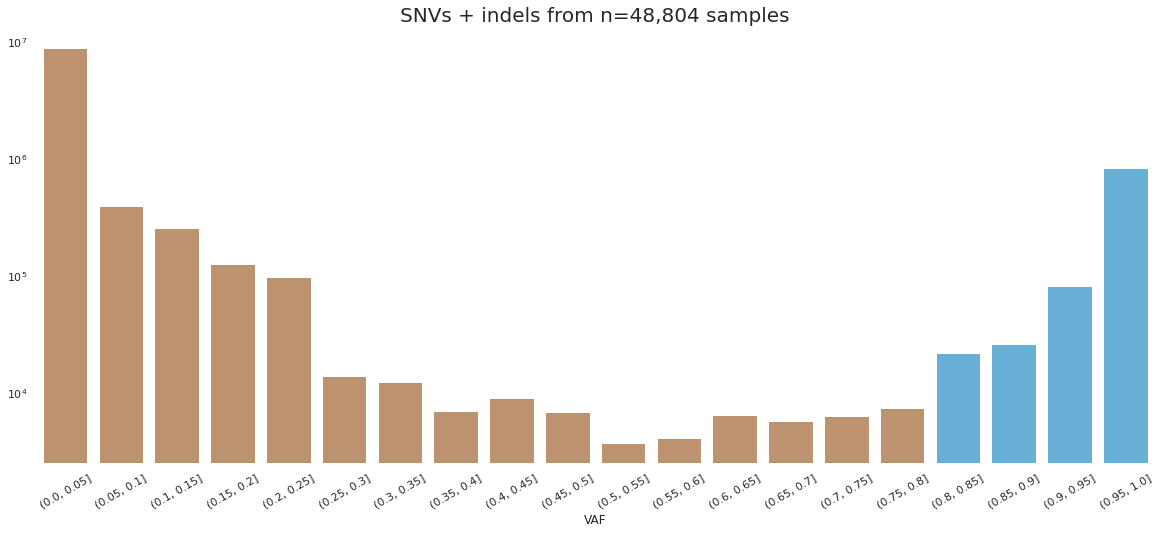

In [216]:
fig = plot_vaf(clonal_data=clonal_variants, subclonal_data=subclonal_variants, title="SNVs + indels from n=48,804 samples")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies.jpg'), dpi=600)

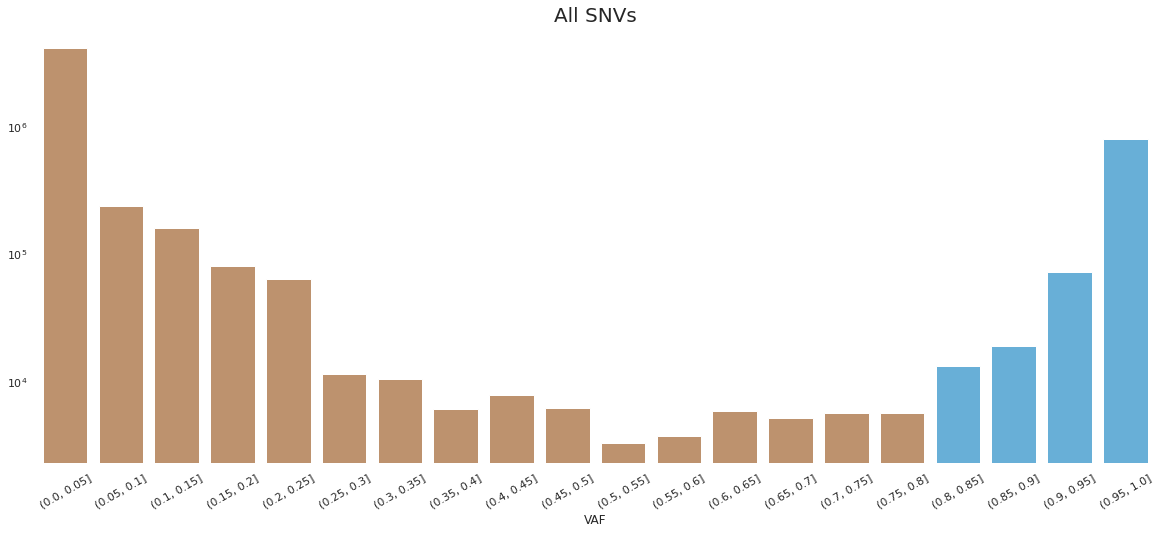

In [217]:
fig = plot_vaf(clonal_data=clonal_snvs, subclonal_data=subclonal_snvs, title="All SNVs")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_snvs.jpg'), dpi=600)

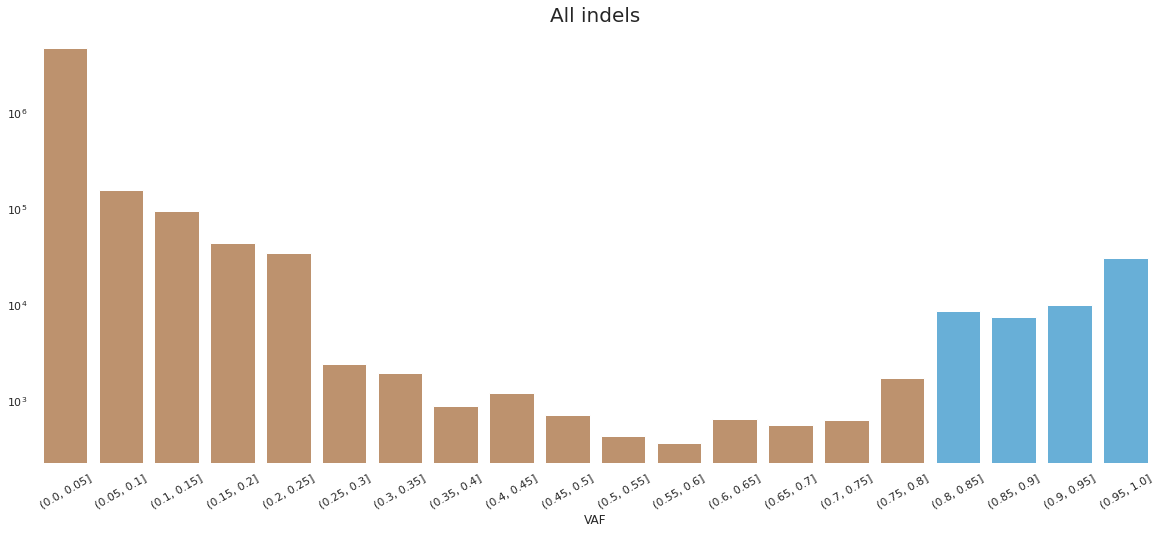

In [218]:
fig = plot_vaf(clonal_data=clonal_indels, subclonal_data=subclonal_indels, title="All indels")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_indels.jpg'), dpi=600)

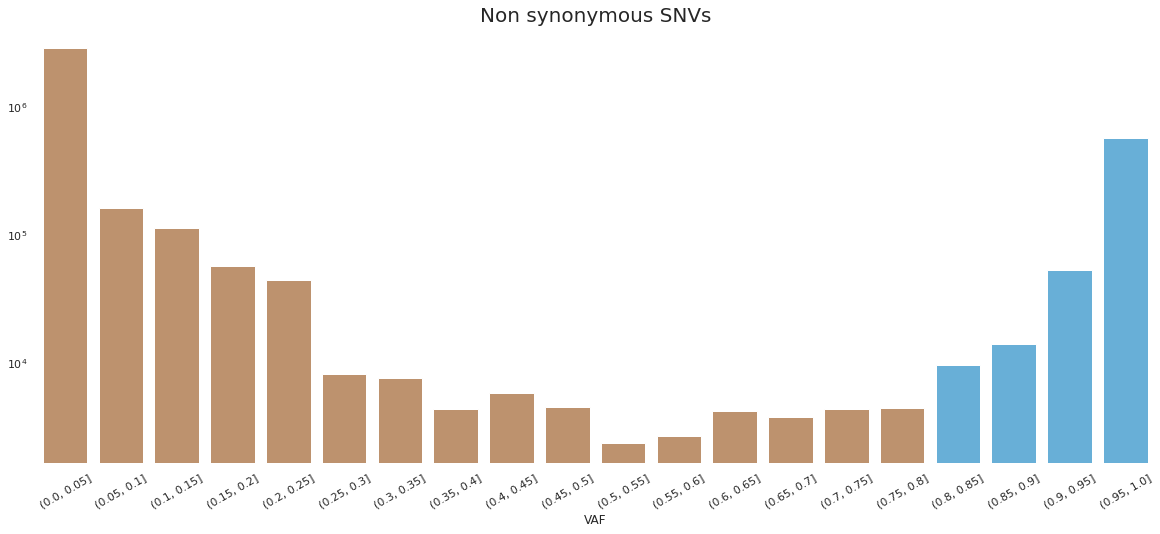

In [219]:
fig = plot_vaf(clonal_data=clonal_snvs_non_synonymous, subclonal_data=subclonal_snvs_non_synonymous, title="Non synonymous SNVs")
fig.savefig(os.path.join(figure_output_folder, 'figure_01_allele_frequencies_snvs_non_synonymous.jpg'), dpi=600)

### Filter out samples

We may want to filter out some samples with extreme counts of variants. A similar approach has already been done using the count of clonal SNVs and indels separately. All samples with a count greater than the median plus three times the inter-quartile range were excluded.

#### Number of subclonal SNVs per sample

[None, Text(0.5, 0, '# SNVs')]

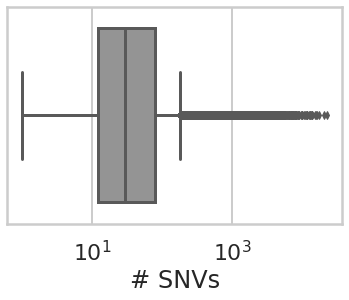

In [20]:
count_subclonal_snvs_per_samples = subclonal_snvs[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_snvs'})
splot = sns.boxplot(count_subclonal_snvs_per_samples.count_snvs, color=grey)
splot.set(xscale="log", xlabel="# SNVs")

In [21]:
print("Median number of SNVs per sample {}".format(count_subclonal_snvs_per_samples.count_snvs.quantile(0.5)))
iqr_count_subclonal_snvs = count_subclonal_snvs_per_samples.count_snvs.quantile(0.75) - count_subclonal_snvs_per_samples.count_snvs.quantile(0.25)
print("IQR number of SNVs per sample {}".format(iqr_count_subclonal_snvs))

Median number of SNVs per sample 29.0
IQR number of SNVs per sample 66.0


In [22]:
count_snvs_threshold = count_subclonal_snvs_per_samples.count_snvs.quantile(0.5) + (3 * iqr_count_subclonal_snvs)
excluded_samples_count_snvs = count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold]["sample"].unique()
print("Filtering all samples with a count of SNVs greater than {}, {} samples and {} SNVs are filtered out".format(
    count_snvs_threshold,
    excluded_samples_count_snvs.shape[0],
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples.count_snvs > count_snvs_threshold].count_snvs.sum()))

Filtering all samples with a count of SNVs greater than 227.0, 3345 samples and 2761008 SNVs are filtered out


#### Number of subclonal indels per samples

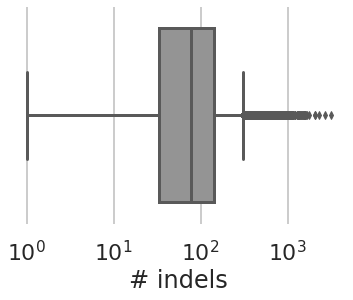

In [23]:
count_subclonal_indels_per_samples = subclonal_indels[["sample", "variant_id"]].groupby("sample").count().reset_index().rename(columns={'variant_id': 'count_indels'})
splot = sns.boxplot(count_subclonal_indels_per_samples.count_indels, color=grey)
splot.set(xscale="log", xlabel="# indels")
sns.despine(bottom=True, left=True)

In [24]:
print("Median number of indels per sample {}".format(count_subclonal_indels_per_samples.count_indels.quantile(0.5)))
iqr_count_subclonal_indels = count_subclonal_indels_per_samples.count_indels.quantile(0.75) - count_subclonal_indels_per_samples.count_indels.quantile(0.25)
print("IQR number of indels per sample {}".format(iqr_count_subclonal_indels))

Median number of indels per sample 77.0
IQR number of indels per sample 110.0


In [25]:
count_indels_threshold = count_subclonal_indels_per_samples.count_indels.quantile(0.5) + (3 * iqr_count_subclonal_indels)
excluded_samples_count_indels = count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold]["sample"].unique()
print("Filtering all samples with a count of indels greater than {}, {} samples and {} indels are filtered out".format(
    count_indels_threshold,
    excluded_samples_count_indels.shape[0],
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples.count_indels > count_indels_threshold].count_indels.sum()))

Filtering all samples with a count of indels greater than 407.0, 954 samples and 564611 indels are filtered out


In [26]:
len(set(excluded_samples_count_indels).intersection(excluded_samples_count_snvs))

727

In [27]:
excluded_samples_by_count_variants = set(excluded_samples_count_indels).union(excluded_samples_count_snvs)
print("Filtered {} indels after excluding all samples".format(
    count_subclonal_indels_per_samples[count_subclonal_indels_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_indels.sum()))
print("Filtered {} SNVs after excluding all samples".format(
    count_subclonal_snvs_per_samples[count_subclonal_snvs_per_samples["sample"].isin(excluded_samples_by_count_variants)].count_snvs.sum()))

Filtered 1119353 indels after excluding all samples
Filtered 2793990 SNVs after excluding all samples


### Sample distribution and number of subclonal SNVs by technology

In [28]:
colors_library_strategy = {
    "RNA-Seq": blue,
    "Targeted-Capture": orange,
    "WGS": green,
    "WGA": grey
}

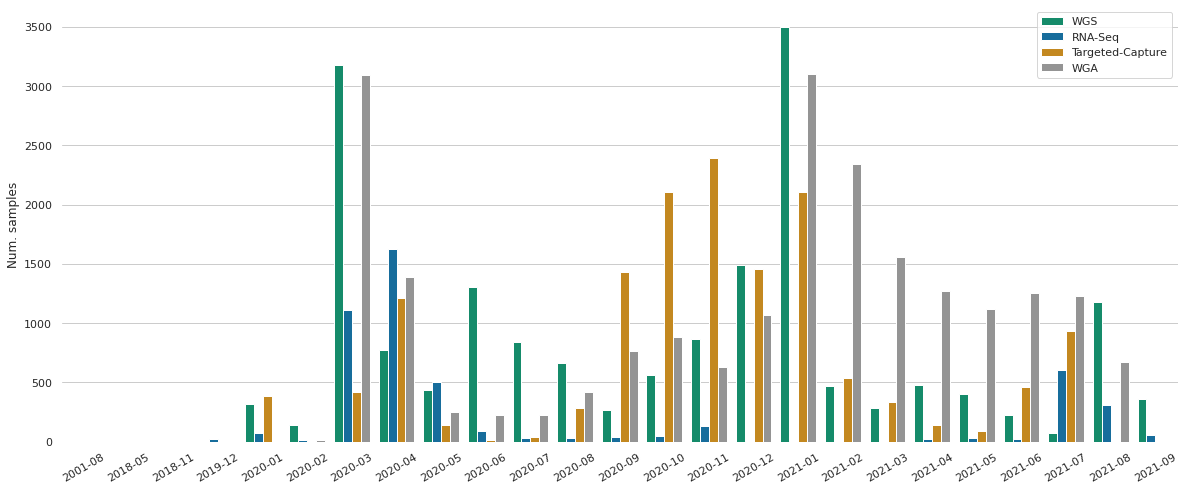

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))
splot = sns.barplot(data=sample_ena[["library_strategy", "run_accession", "month"]].groupby(["month", "library_strategy"]).count().reset_index(), 
            y="run_accession", x="month", hue='library_strategy', palette=colors_library_strategy)
plt.xticks(rotation=30)
ax.legend(loc='upper right')
splot.set(xlabel=None, ylabel=None)
plt.ylabel("Num. samples")
sns.despine(bottom=True, left=True)
fig.savefig(os.path.join(figure_output_folder, "figure_02_distribution_samples_through_time_by_technology.jpg"), dpi=600)

In [225]:
def plot_subclonal_per_sample(subclonal_data, sample_data, title=None):
    count_subclonal_snvs_per_sample_and_library_strategy = pd.merge(
        left=subclonal_data[["sample", "variant_id"]], 
        right=sample_data[["run_accession", "library_strategy"]],
        left_on="sample", right_on="run_accession", how="inner")[["sample", "variant_id", "library_strategy"]] \
    .groupby(["sample", "library_strategy"]).count().reset_index().rename(columns={'variant_id': 'count_snvs'})
    count_subclonal_snvs_per_sample_and_library_strategy.sort_values("library_strategy", inplace=True)
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    splot = sns.boxplot(data=count_subclonal_snvs_per_sample_and_library_strategy, x="count_snvs", y="library_strategy", palette=colors_library_strategy)
    splot.set(xscale="log", xlabel=None, ylabel=None)
    plt.title(title, size=20)
    plt.tight_layout()
    sns.despine(bottom=True, left=True)
    return splot.figure

In [31]:
data = pd.merge(
        left=subclonal_snvs[["sample", "variant_id"]], 
        right=sample_ena[["run_accession", "library_strategy"]],
        left_on="sample", right_on="run_accession", how="inner")[["sample", "variant_id", "library_strategy"]] \
    .groupby(["sample", "library_strategy"]).count().reset_index().rename(columns={'variant_id': 'count_snvs'})
np.median(data[data.library_strategy == "Targeted-Capture"].count_snvs)

17.0

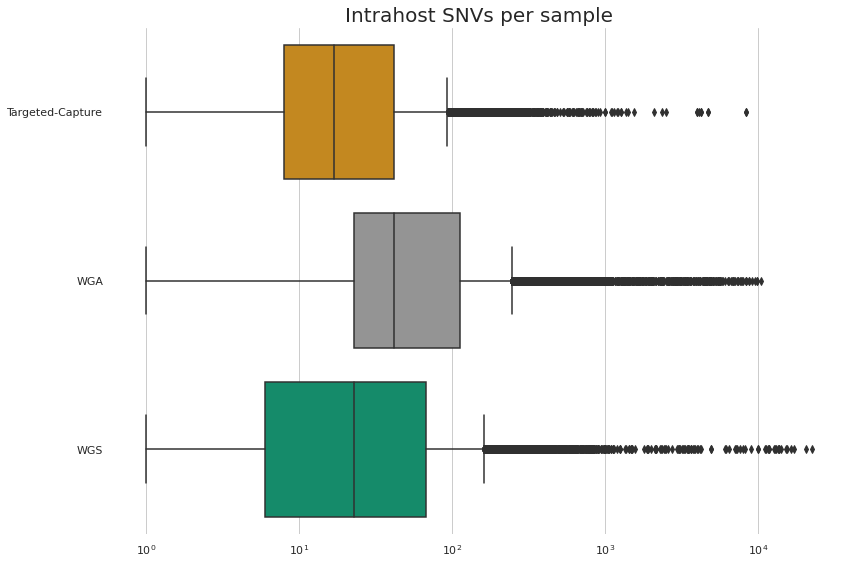

In [239]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs, sample_data=sample_ena, title='Intrahost SNVs per sample')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_snvs_by_technology.jpg"), dpi=600)

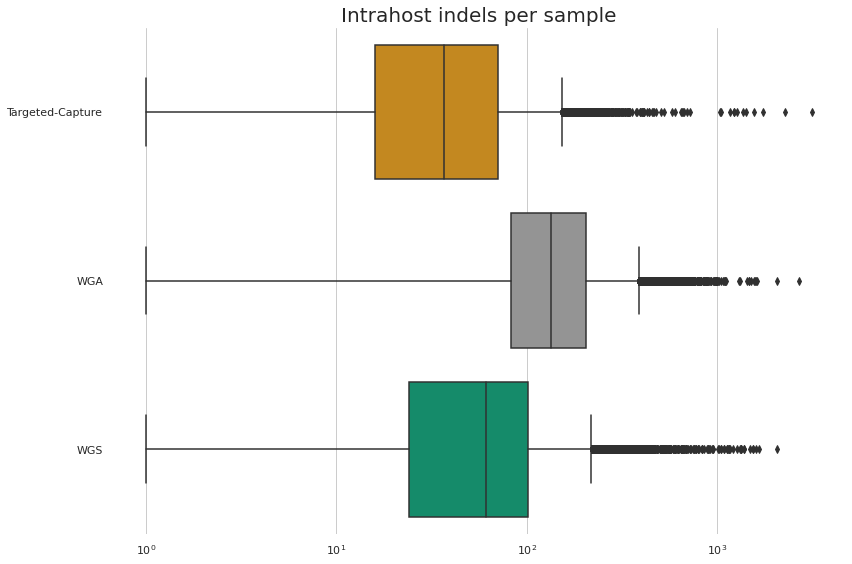

In [238]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_indels, sample_data=sample_ena, title='Intrahost indels per sample')
fig.savefig(os.path.join(figure_output_folder, "figure_03_count_indels_by_technology.jpg"), dpi=600)

In [34]:
# excludes samples effectively
excluded_samples = sample_ena[(sample_ena.run_accession.isin(excluded_samples_by_count_variants)) | (sample_ena.library_strategy == "RNA-Seq")].run_accession.unique()
sample_ena_filtered_samples = sample_ena[~sample_ena.run_accession.isin(excluded_samples)]
subclonal_snvs_filtered_samples = subclonal_snvs[~subclonal_snvs["sample"].isin(excluded_samples)]
subclonal_indels_filtered_samples = subclonal_indels[~subclonal_indels["sample"].isin(excluded_samples)]
print("Total excluded samples: {}".format(excluded_samples.shape[0]))

Total excluded samples: 8349


### Filter out low quality SNVs

* Filter out SNVs with too high coverage at the position. The distribution of DP has a long tail on the higher end, thus we filter out anything above the 99th percentile.
* The quality reported by LoFreq is not a Phred score. We filter out variant calls with quality less than or equal to 50.
* We filter variant calls with a strand bias score (ie: the lower the better) greater than 100.
* The number of supporting reads is calculated using the VAF and the DP. All variant calls with less than 10 supporting reads are filtered out.
* Finally, we filter all variant calls with a VAF lower than 0.01

The above rules allows us to filter down to **18.23 % of unique subclonal variants** and to **1.05 % of subclonal variant calls**. This represents **17.46 % of all possible SARS-CoV-2 mutations**.

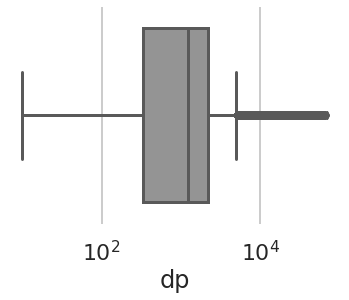

In [35]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.dp, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_dp_boxplot.jpg"), dpi=200)

In [36]:
subclonal_snvs_filtered_samples.dp.quantile(0.99)

19398.699999999953

In [37]:
DP_UPPER_THRESHOLD = subclonal_snvs_filtered_samples.dp.quantile(0.99)
print("Filtering all variants on positions with DP > {} removes {} variants".format(DP_UPPER_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.dp > DP_UPPER_THRESHOLD].shape[0]))

Filtering all variants on positions with DP > 19398.699999999953 removes 20042 variants


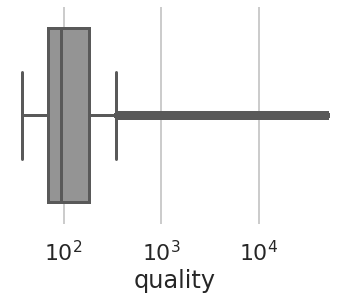

In [38]:
splot = sns.boxplot(subclonal_snvs_filtered_samples.quality, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_quality_boxplot.jpg"), dpi=200)

In [39]:
QUALITY_THRESHOLD = 50 #subclonal_snvs.quality.quantile(0.01)
print("Filtering all variants on positions with quality <= {} removes {} variants".format(QUALITY_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.quality <= QUALITY_THRESHOLD].shape[0]))

Filtering all variants on positions with quality <= 50 removes 18059 variants


In [40]:
print("There are {} extreme values for strand bias".format(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > 1000000].shape[0]))

There are 2 extreme values for strand bias


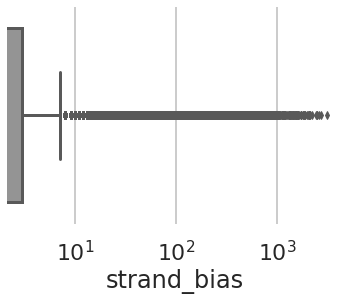

In [41]:
splot = sns.boxplot(subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias < 1000000].strand_bias, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_strand_bias_boxplot.jpg"), dpi=200)

In [42]:
STRAND_BIAS_THRESHOLD = 100
print("Filtering all variants on positions with strand bias > {} removes {} variants".format(
    STRAND_BIAS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.strand_bias > STRAND_BIAS_THRESHOLD].shape[0]))

Filtering all variants on positions with strand bias > 100 removes 6972 variants


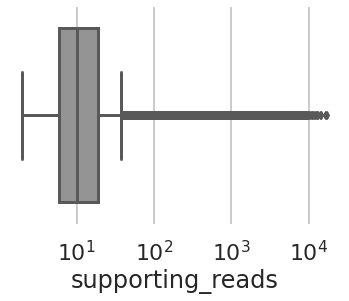

In [43]:
subclonal_snvs_filtered_samples["supporting_reads"] = subclonal_snvs_filtered_samples.vaf * subclonal_snvs_filtered_samples.dp
splot = sns.boxplot(subclonal_snvs_filtered_samples.supporting_reads, color=grey)
splot.set(xscale="log")
sns.despine(bottom=True, left=True)
splot.figure.savefig(os.path.join(figure_output_folder, "figure_04_supporting_reads_boxplot.jpg"), dpi=200)

In [44]:
SUPPORTING_READS_THRESHOLD = 3
print("Filtering all variants on positions with supporting_reads < {} removes {} variants".format(
    SUPPORTING_READS_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.supporting_reads < SUPPORTING_READS_THRESHOLD].shape[0]))

Filtering all variants on positions with supporting_reads < 3 removes 228872 variants


In [45]:
MINIMUM_VAF_THRESHOLD = 0.001
print("Filtering all variants with VAF < {} removes {} variants".format(MINIMUM_VAF_THRESHOLD, subclonal_snvs_filtered_samples[subclonal_snvs_filtered_samples.vaf < MINIMUM_VAF_THRESHOLD].shape[0]))

Filtering all variants with VAF < 0.001 removes 1054 variants


In [46]:
def filter_out_variants(data, dp_upper_threshold=DP_UPPER_THRESHOLD, quality_threshold=QUALITY_THRESHOLD, strand_bias_threshold=STRAND_BIAS_THRESHOLD,
                       supporting_reads_threshold=SUPPORTING_READS_THRESHOLD, minimum_vaf_threshold=MINIMUM_VAF_THRESHOLD):
    data_filtered_variants = data[
        (data.dp <= dp_upper_threshold) &
        (data.quality > quality_threshold) &
        (data.strand_bias <= strand_bias_threshold) &
        (data.supporting_reads >= supporting_reads_threshold) &
        (data.vaf >= minimum_vaf_threshold)
    ]
    print("Filtered subclonal SNV calls {}".format(data.shape[0] - data_filtered_variants.shape[0]))
    print("Subclonal SNV calls after filtering {}".format(data_filtered_variants.shape[0]))
    count_unique_after_filtering = data_filtered_variants.variant_id.unique().shape[0]
    print("Subclonal unique SNVs after filtering {} ({} % of all possible mutations)".format(count_unique_after_filtering, round(count_unique_after_filtering / (SARS_COV_2_GENOME_LENGTH * 3) * 100, 3)))
    return data_filtered_variants

In [47]:
subclonal_snvs_filtered_vaf0_sr0 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.0, supporting_reads_threshold=0)

Filtered subclonal SNV calls 44129
Subclonal SNV calls after filtering 1960002
Subclonal unique SNVs after filtering 81222 (90.539 % of all possible mutations)


In [48]:
subclonal_snvs_filtered_vaf001 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.01)

Filtered subclonal SNV calls 1219092
Subclonal SNV calls after filtering 785039
Subclonal unique SNVs after filtering 71458 (79.655 % of all possible mutations)


In [49]:
subclonal_snvs_filtered_vaf002 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.02)

Filtered subclonal SNV calls 1530585
Subclonal SNV calls after filtering 473546
Subclonal unique SNVs after filtering 64051 (71.399 % of all possible mutations)


In [50]:
subclonal_snvs_filtered_vaf003 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.03)

Filtered subclonal SNV calls 1655437
Subclonal SNV calls after filtering 348694
Subclonal unique SNVs after filtering 58273 (64.958 % of all possible mutations)


In [51]:
subclonal_snvs_filtered_vaf005 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.05)

Filtered subclonal SNV calls 1775578
Subclonal SNV calls after filtering 228553
Subclonal unique SNVs after filtering 48818 (54.418 % of all possible mutations)


In [52]:
subclonal_snvs_filtered_vaf01 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.1)

Filtered subclonal SNV calls 1877978
Subclonal SNV calls after filtering 126153
Subclonal unique SNVs after filtering 33743 (37.614 % of all possible mutations)


In [53]:
subclonal_snvs_filtered_vaf02 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.2)

Filtered subclonal SNV calls 1933639
Subclonal SNV calls after filtering 70492
Subclonal unique SNVs after filtering 18976 (21.153 % of all possible mutations)


In [54]:
subclonal_snvs_filtered_vaf03 = filter_out_variants(subclonal_snvs_filtered_samples, minimum_vaf_threshold=0.3)

Filtered subclonal SNV calls 1956474
Subclonal SNV calls after filtering 47657
Subclonal unique SNVs after filtering 11857 (13.217 % of all possible mutations)


In [55]:
subclonal_snvs_filtered_samples["sample"].unique().shape

(44817,)

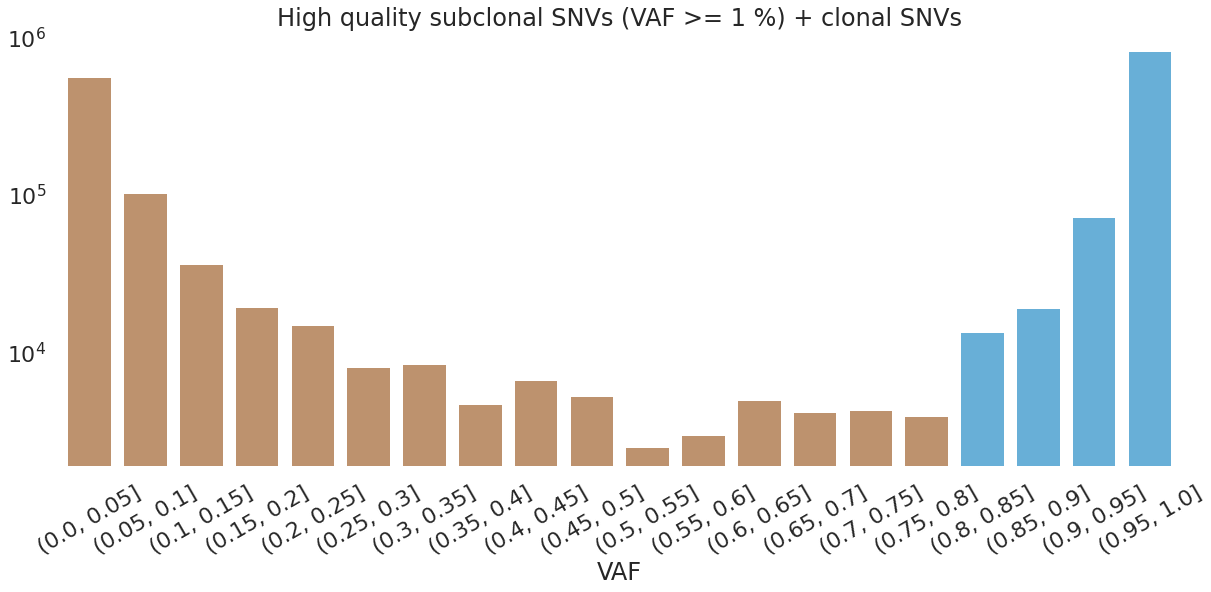

In [56]:
fig = plot_vaf(clonal_data=clonal_snvs, subclonal_data=subclonal_snvs_filtered_vaf001, title="High quality subclonal SNVs (VAF >= 1 %) + clonal SNVs")


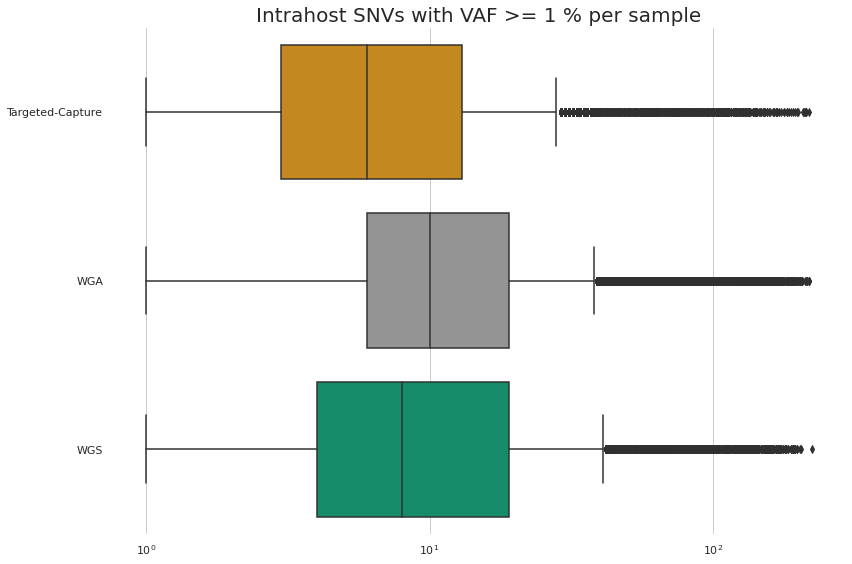

In [230]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf001, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 1 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_1.jpg"), dpi=600)

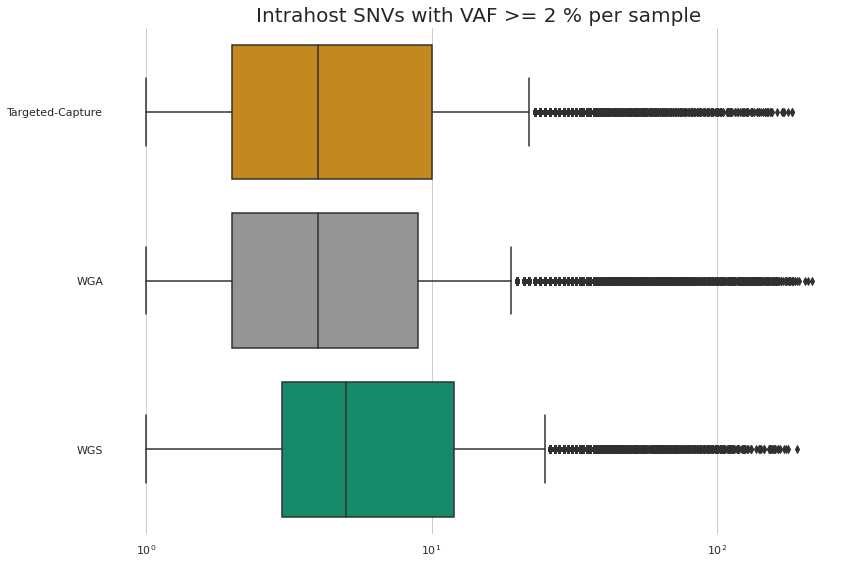

In [232]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf002, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 2 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_2.jpg"), dpi=600)

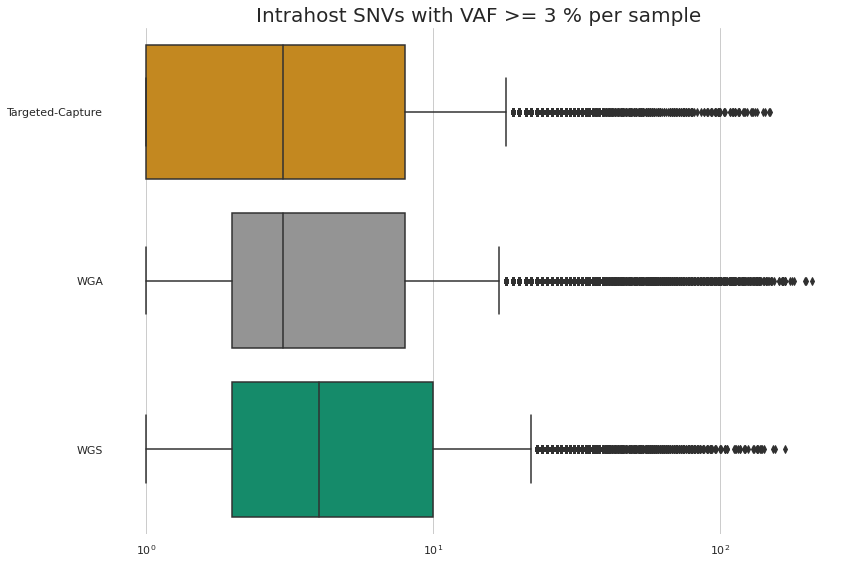

In [233]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf003, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 3 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_3.jpg"), dpi=600)

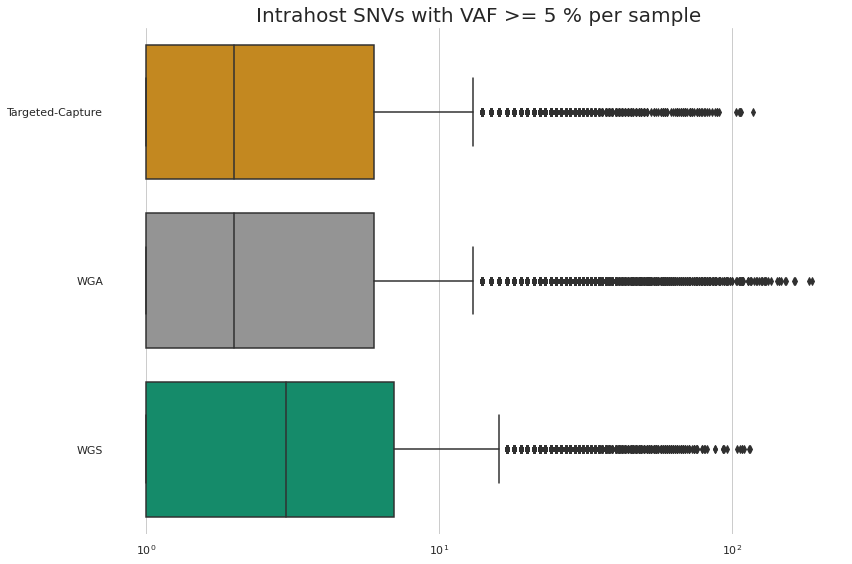

In [234]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf005, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 5 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_5.jpg"), dpi=600)

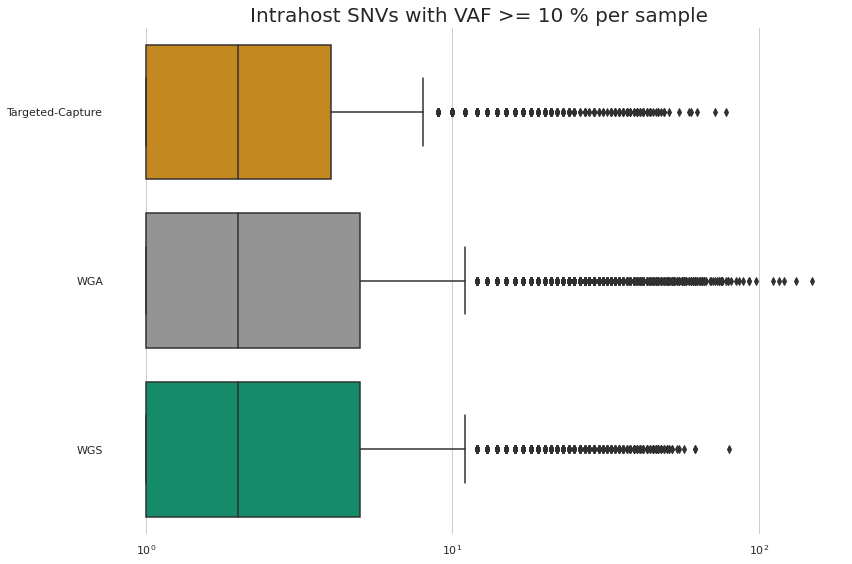

In [235]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf01, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 10 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_10.jpg"), dpi=600)

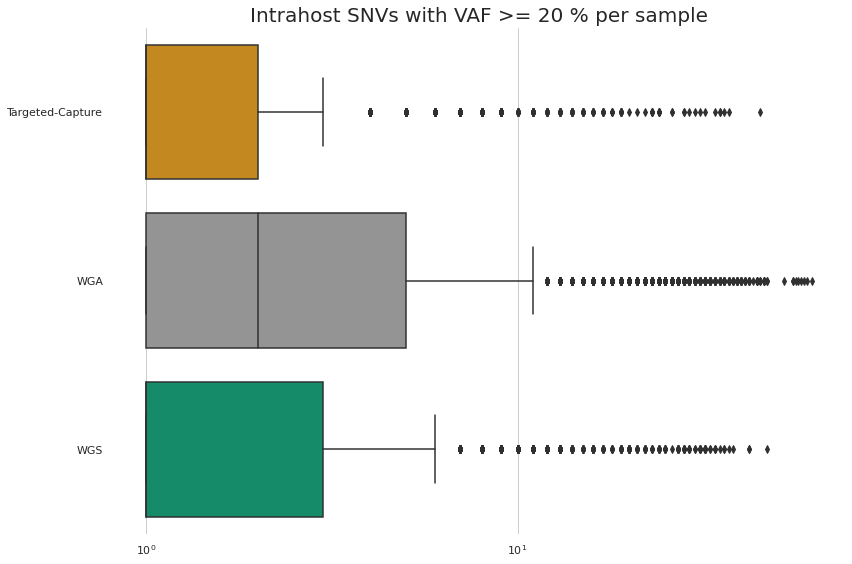

In [236]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf02, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 20 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_20.jpg"), dpi=600)

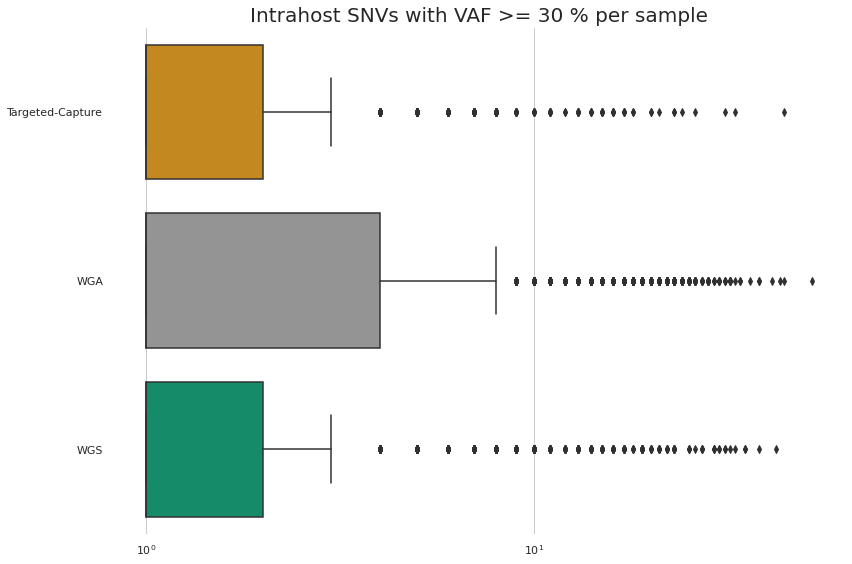

In [237]:
fig = plot_subclonal_per_sample(subclonal_data=subclonal_snvs_filtered_vaf03, sample_data=sample_ena_filtered_samples, title="Intrahost SNVs with VAF >= 30 % per sample")
fig.savefig(os.path.join(figure_output_folder, "figure_04_count_snvs_by_technology_after_filtering_vaf_30.jpg"), dpi=600)

### Recurrent subclonal variants

In [119]:
def filter_out_non_recurrent_variants(data, recurrence_threshold=2):
    counts = data[["variant_id", "sample"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count"})
    non_recurrent_variant_ids = counts[counts["count"] < recurrence_threshold].variant_id
    data_filtered = data[~data.variant_id.isin(non_recurrent_variant_ids)]
    print("Filtered out {} unique variants and {} variant calls".format(non_recurrent_variant_ids.shape[0], data.shape[0] - data_filtered.shape[0]))
    return data_filtered

In [120]:
subclonal_snvs_filtered_samples_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0)

Filtered out 10067 unique variants and 10067 variant calls


In [121]:
subclonal_snvs_filtered_samples_recurrence3 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=3)

Filtered out 18865 unique variants and 27663 variant calls


In [122]:
subclonal_snvs_filtered_samples_recurrence4 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf0_sr0, recurrence_threshold=4)

Filtered out 25512 unique variants and 47604 variant calls


In [123]:
subclonal_snvs_filtered_samples_vaf001_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf001)

Filtered out 14956 unique variants and 14956 variant calls


In [124]:
subclonal_snvs_filtered_samples_vaf01_sr3_recurrence2 = filter_out_non_recurrent_variants(data=subclonal_snvs_filtered_vaf01)

Filtered out 17575 unique variants and 17575 variant calls


## Variant allele frequency distribution through time

1,132 samples were excluded due to a missing collection date.

In [125]:
count_subclonal_variants_per_sample = subclonal_snvs_filtered_vaf002[["sample", "variant_id"]].groupby("sample").count().reset_index()
count_subclonal_variants_per_sample.head()

sample  variant_id
0   DRR297968           9
1  ERR4192740          31
2  ERR4204119           4
3  ERR4204166          20
4  ERR4204180          82

In [126]:
samples_with_counts = pd.merge(left=sample_ena_filtered_samples[["run_accession", "month"]], right=count_subclonal_variants_per_sample, left_on="run_accession", right_on="sample", how="inner")
samples_with_counts.head()

run_accession    month      sample  variant_id
0    ERR6360438  2021-06  ERR6360438          10
1    ERR6360437  2021-06  ERR6360437           5
2    ERR6360435  2021-06  ERR6360435           5
3    ERR6356170  2021-07  ERR6356170           5
4    ERR6360442  2021-06  ERR6360442           4

In [127]:
samples_with_counts.shape

(40970, 4)

In [128]:
subclonal_variant_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002[["sample", "vaf"]], right=sample_ena_filtered_samples[["run_accession", "month"]], right_on="run_accession", left_on="sample", how="inner")

In [129]:
sample_counts_per_month = samples_with_counts[["month", "sample"]].groupby("month").count().reset_index()
sample_counts_per_month.head()

month  sample
0  2020-01     493
1  2020-02      91
2  2020-03    5520
3  2020-04    2678
4  2020-05     618

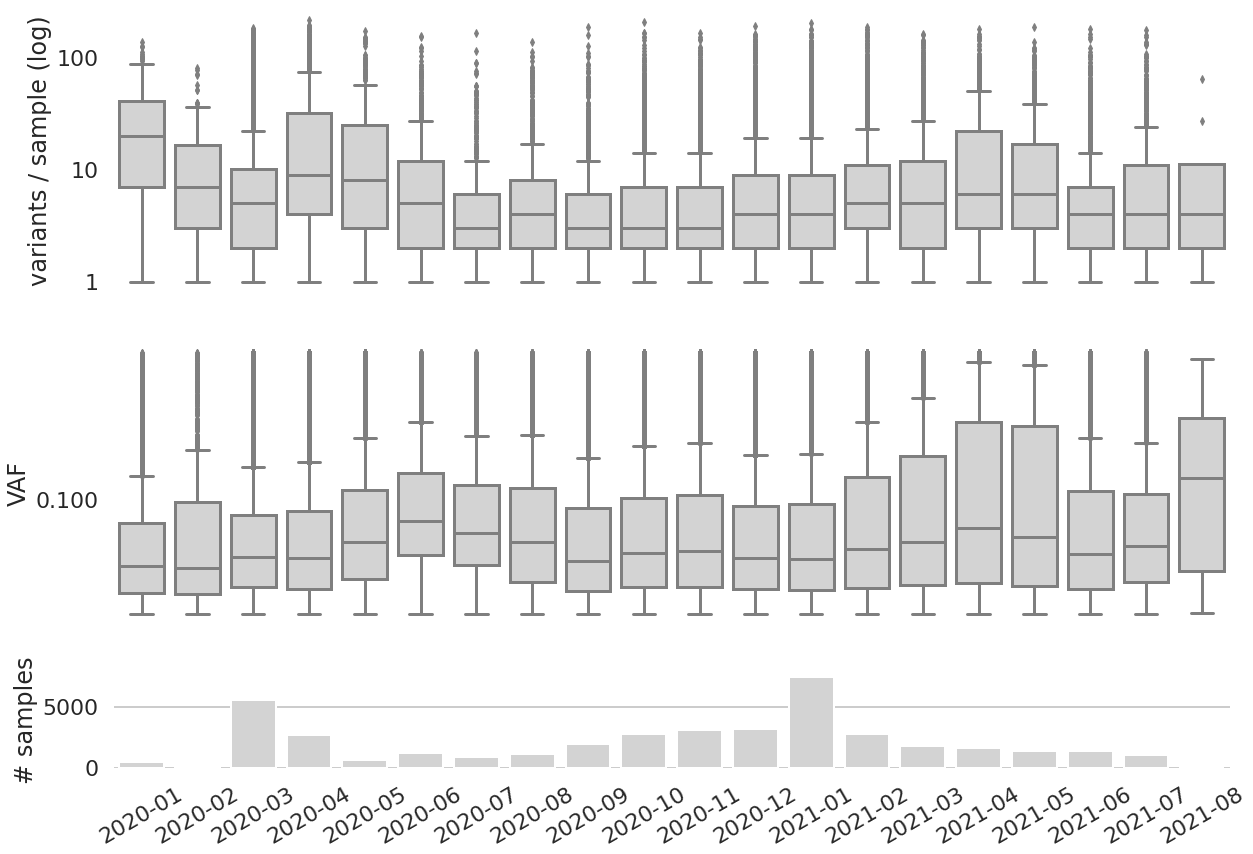

In [130]:
fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3, 1]})
sns.boxplot(data=samples_with_counts.sort_values("month"), y="variant_id", x="month", ax=ax1, color='lightgrey')
sns.boxplot(data=subclonal_variant_with_month.sort_values("month"), y="vaf", x="month", ax=ax2, color='lightgrey')
sns.barplot(data=sample_counts_per_month, y="sample", x="month", ax=ax3, color='lightgrey')
ax1.set_ylabel("variants / sample (log)")
ax2.set_ylabel("VAF")
ax3.set_ylabel("# samples")
ax1.set_yscale('log')
ax2.set_yscale('log')
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax3.set_xlabel(None)
plt.xticks(rotation=30)
sns.despine(bottom=True, left=True)
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.yaxis.set_major_formatter(ScalarFormatter())
ax1.ticklabel_format(style='plain', axis='y')
ax2.yaxis.set_major_formatter(ScalarFormatter())
ax2.ticklabel_format(style='plain', axis='y')
fig.savefig(os.path.join(figure_output_folder, "figure_05_subclonal_variant_allele_frequencies_evolution.jpg"), dpi=600)

## Population allele frequency of subclonal and clonal variants through time

In [131]:
all_variants = pd.concat([clonal_variants.loc[:, ["sample", "variant_id"]], subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]]])
all_variants = pd.merge(left=all_variants, right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
all_variants.head()

sample variant_id run_accession    month
0  ERR6426655  26217:G>T    ERR6426655  2021-07
1  ERR6426655   4181:G>T    ERR6426655  2021-07
2  ERR6426655  17040:T>C    ERR6426655  2021-07
3  ERR6426655   7124:C>T    ERR6426655  2021-07
4  ERR6426655  27638:T>C    ERR6426655  2021-07

In [132]:
sample_counts_per_month["sample_cumsum"] = sample_counts_per_month.sort_values("month")["sample"].cumsum()
sample_counts_per_month.head()

month  sample  sample_cumsum
0  2020-01     493            493
1  2020-02      91            584
2  2020-03    5520           6104
3  2020-04    2678           8782
4  2020-05     618           9400

In [133]:
def plot_allele_frequencies_through_time(data, sample_counts_per_month, title):
    count_samples = data["sample"].unique().shape[0]
    count_variant_recurrence_per_month = data[["month", "sample", "variant_id"]].groupby(["month", "variant_id"]).count().reset_index()
    count_variant_recurrence_per_month.sort_values("month", inplace=True)
    count_variant_recurrence_per_month.rename(columns={"sample": "count"}, inplace=True)
    count_variant_recurrence_per_month["cumsum"] = count_variant_recurrence_per_month.groupby("variant_id")['count'].cumsum()
    count_variant_recurrence_per_month_with_sample_counts = pd.merge(left=count_variant_recurrence_per_month, right=sample_counts_per_month, on="month")
    count_variant_recurrence_per_month_with_sample_counts["af"] = count_variant_recurrence_per_month_with_sample_counts["cumsum"] / count_variant_recurrence_per_month_with_sample_counts["sample_cumsum"]
    count_variant_recurrence_per_month_with_sample_counts["af_intramonth"] = count_variant_recurrence_per_month_with_sample_counts["count"] / count_variant_recurrence_per_month_with_sample_counts["sample"]
    
    # plot
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 14), gridspec_kw={'height_ratios': [3, 3]})
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af", ax=ax1, color="lightgrey")
    sns.boxplot(data=count_variant_recurrence_per_month_with_sample_counts, x="month", y="af_intramonth", ax=ax2, color="lightgrey")
    ax1.set_ylabel("accumulated allele frequency")
    ax2.set_ylabel("intra month allele frequency")
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_xlabel(None)
    ax2.set_xlabel(None)
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax2.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax2.yaxis.set_major_formatter(ScalarFormatter())
    ax2.ticklabel_format(style='plain', axis='y')
    ax1.set_title(title)
    fig.savefig(os.path.join(figure_output_folder, "figure_05_population_allele_frequencies_evolution_{}.jpg".format(title.lower().replace(" ", "_"))), dpi=600)

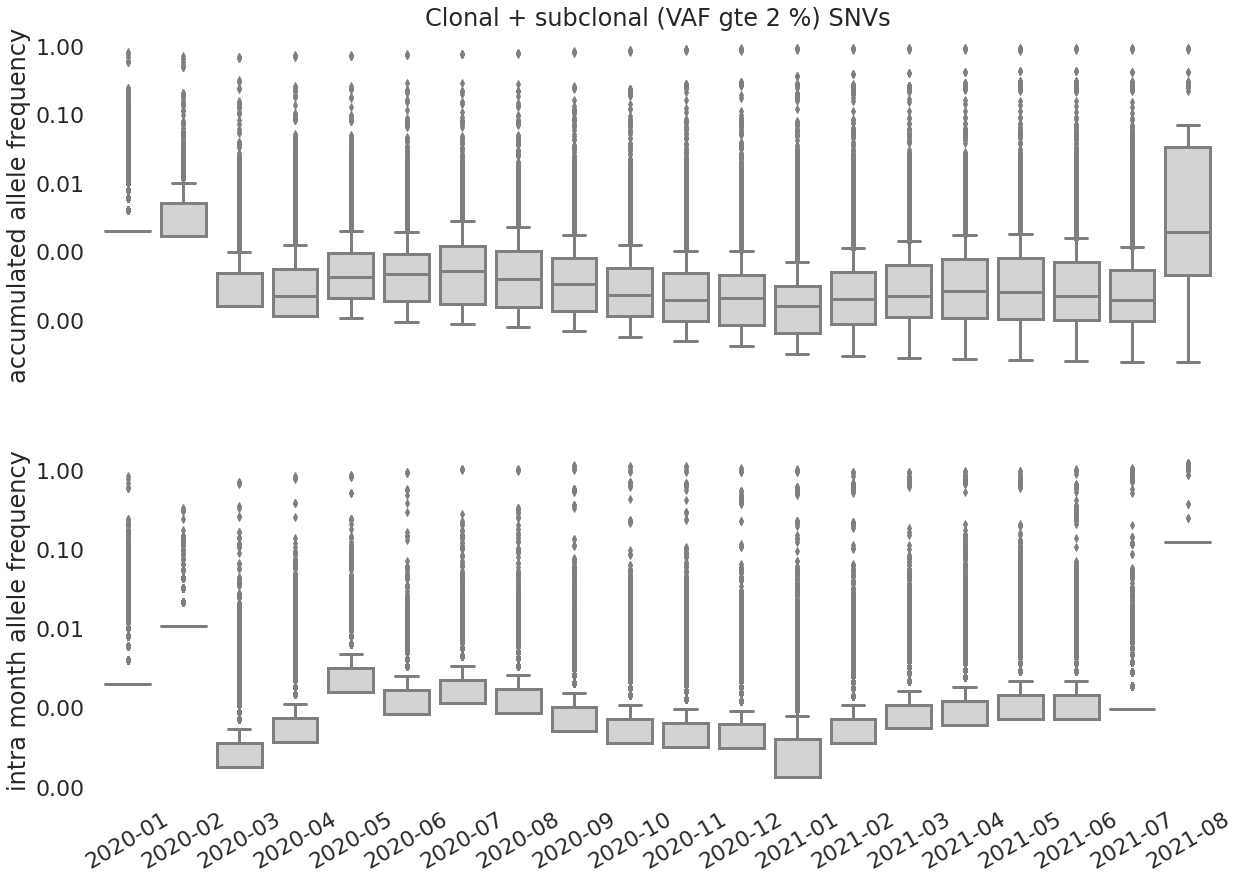

In [134]:
plot_allele_frequencies_through_time(data=all_variants, sample_counts_per_month=sample_counts_per_month, title="Clonal + subclonal (VAF gte 2 %) SNVs")

In [135]:
clonal_variants_with_month = pd.merge(left=clonal_snvs.loc[:, ["sample", "variant_id"]], 
                                      right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                      left_on="sample", 
                                      right_on="run_accession", 
                                      how="inner")

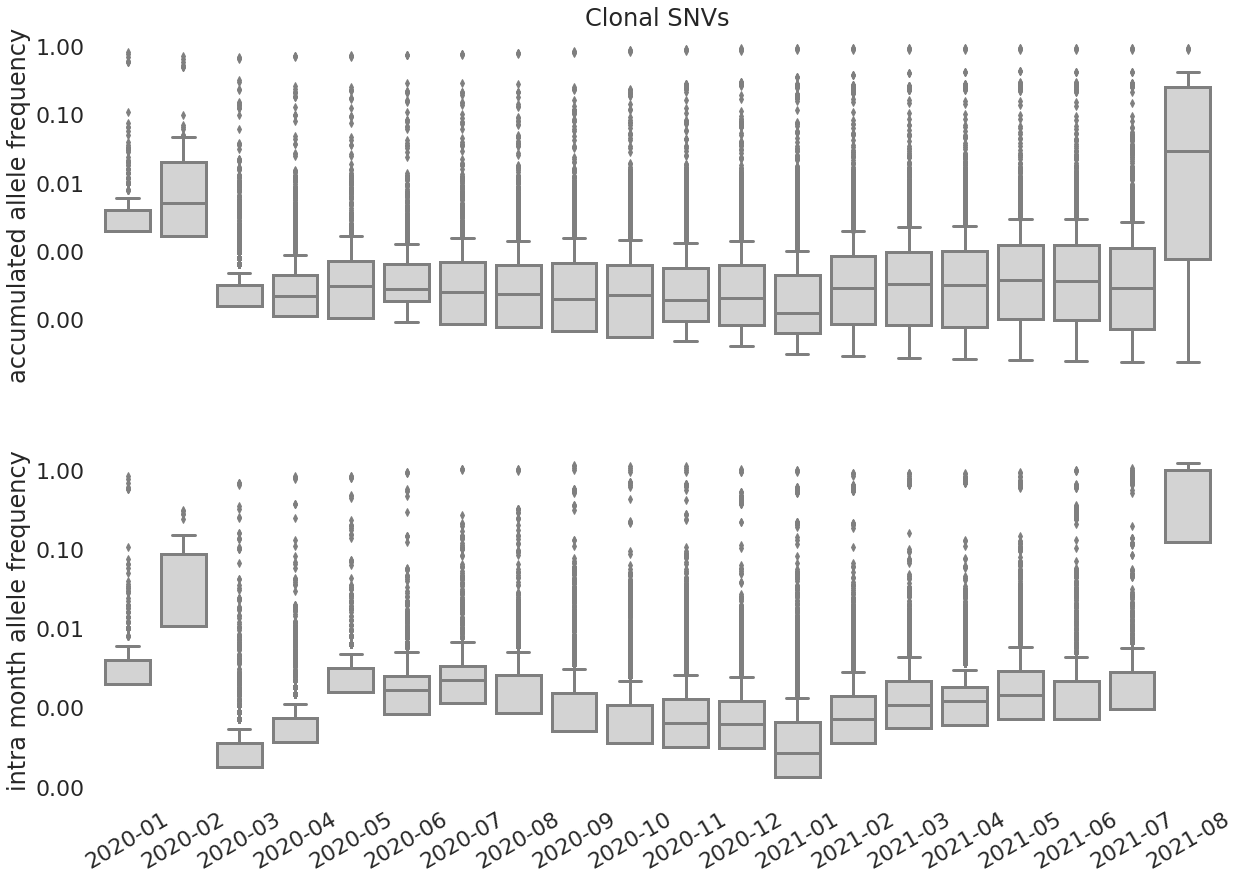

In [136]:
plot_allele_frequencies_through_time(data=clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Clonal SNVs")

In [137]:
subclonal_variants_with_month = pd.merge(left=subclonal_snvs_filtered_vaf002.loc[:, ["sample", "variant_id"]], 
                                         right=sample_ena_filtered_samples[["run_accession", "month"]], 
                                         left_on="sample", 
                                         right_on="run_accession", 
                                         how="inner")

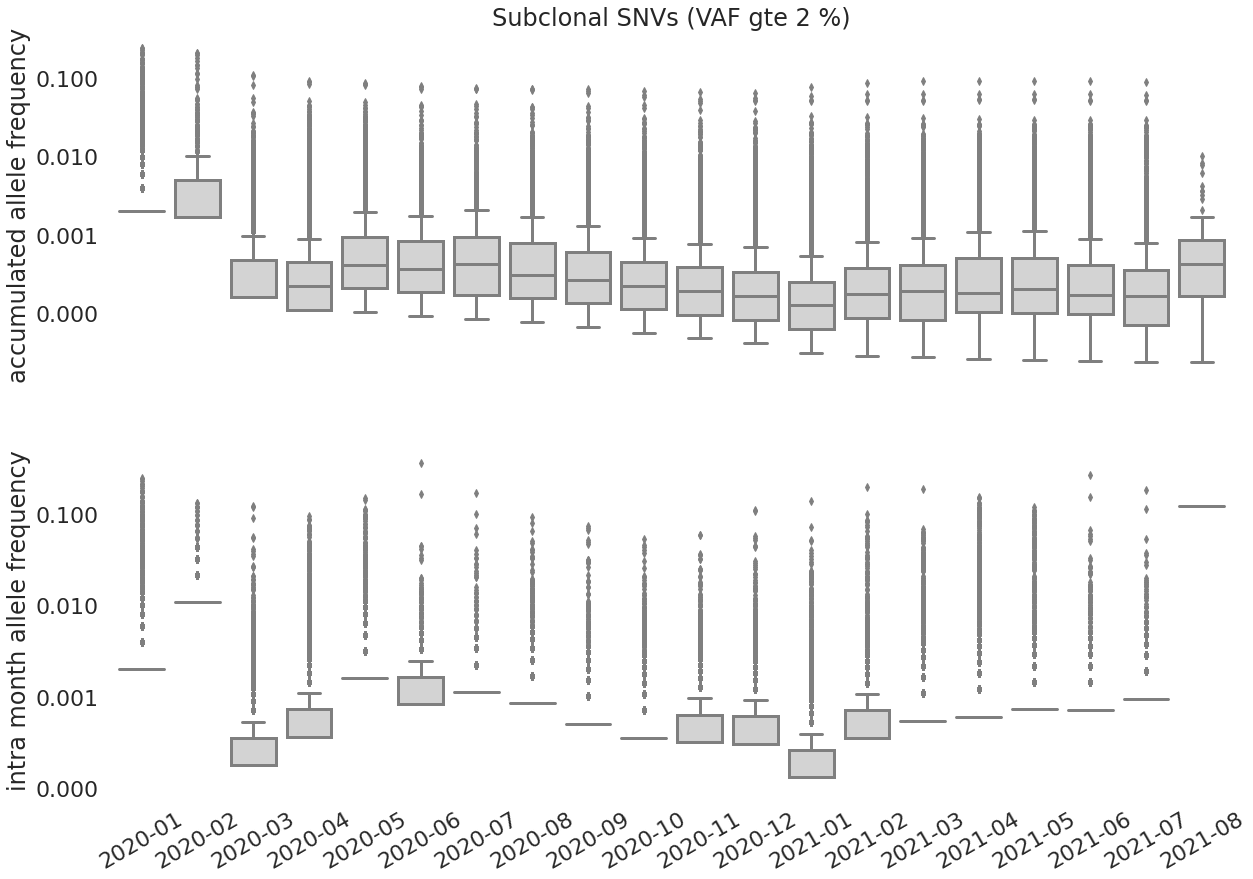

In [138]:
plot_allele_frequencies_through_time(data=subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Subclonal SNVs (VAF gte 2 %)")

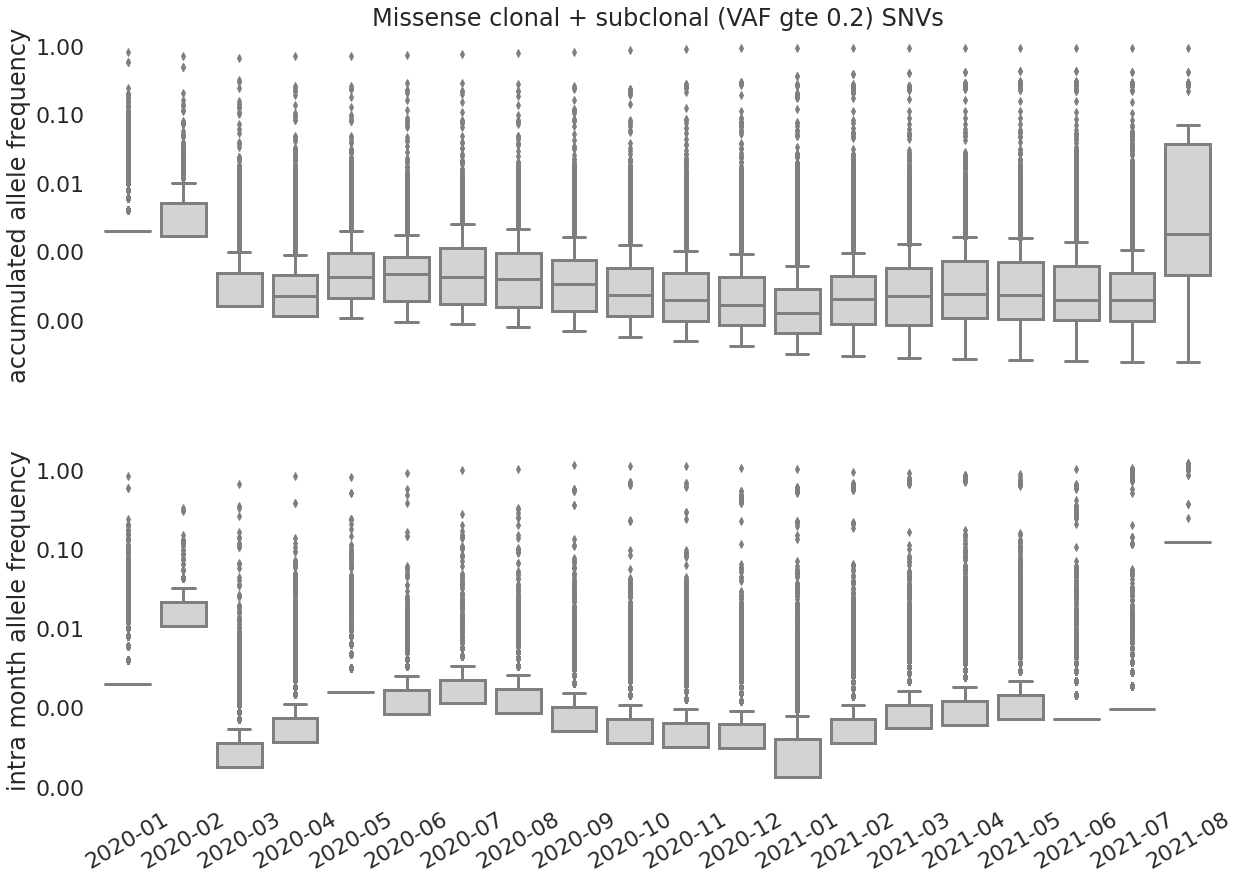

In [139]:
ns_all_variants_with_month = pd.merge(
    left=pd.concat([subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
                    clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]]]),
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_all_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal + subclonal (VAF gte 0.2) SNVs")

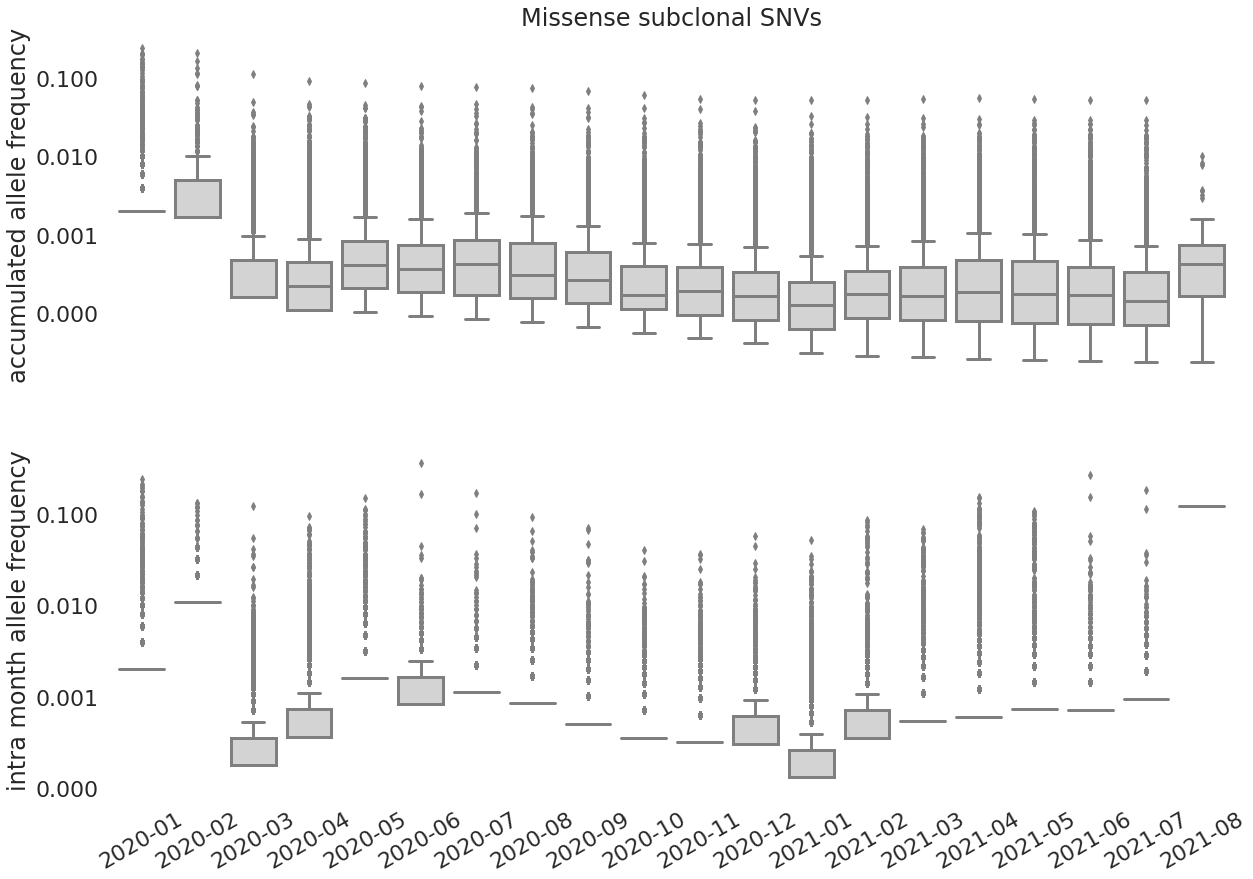

In [140]:
ns_subclonal_variants_with_month = pd.merge(
    left=subclonal_snvs_filtered_vaf002.loc[subclonal_snvs_filtered_vaf002["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_subclonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense subclonal SNVs")

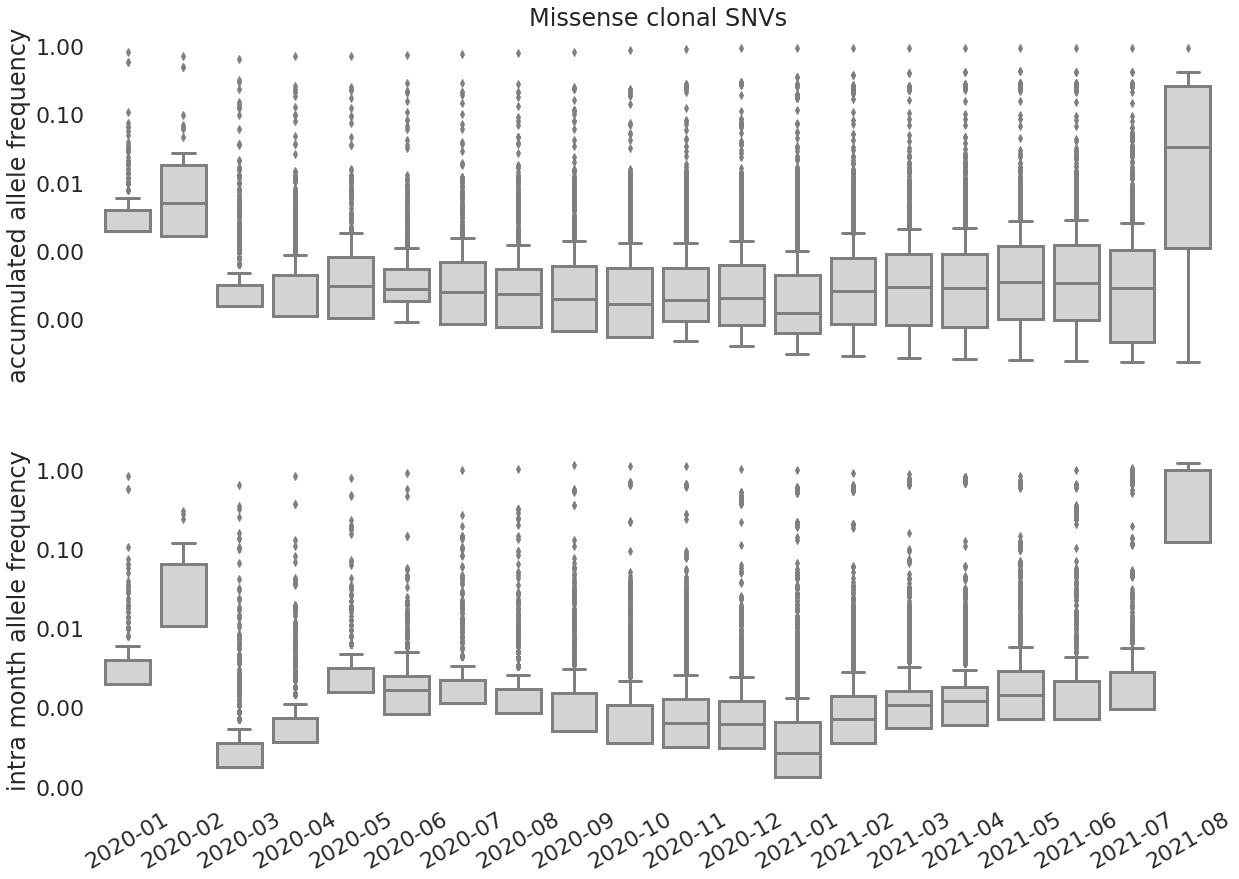

In [141]:
ns_clonal_variants_with_month = pd.merge(
    left=clonal_variants.loc[clonal_variants["annotation_highest_impact"] == "missense_variant", ["sample", "variant_id"]], 
    right=sample_ena_filtered_samples[["run_accession", "month"]], left_on="sample", right_on="run_accession", how="inner")
plot_allele_frequencies_through_time(data=ns_clonal_variants_with_month, sample_counts_per_month=sample_counts_per_month, title="Missense clonal SNVs")

## Correlations between clonal and subclonal

In [142]:
def plot_correlation(sample_data, clonal_data, subclonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    frequencies_subclonal_snvs = subclonal_data[subclonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_subclonal_snvs["af"] = frequencies_subclonal_snvs["sample"] / included_samples.shape[0]
    frequencies_snvs = pd.merge(left=frequencies_clonal_snvs[["variant_id", "af"]], right=frequencies_subclonal_snvs[["variant_id", "af"]], on="variant_id", suffixes=("_clonal", "_subclonal"))
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=frequencies_snvs, x="af_clonal", y="af_subclonal")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("Subclonal abundance")
    plt.title("{} Pearson corr={}".format(title, round(frequencies_snvs.corr().af_subclonal[0], 3)))
    return fig

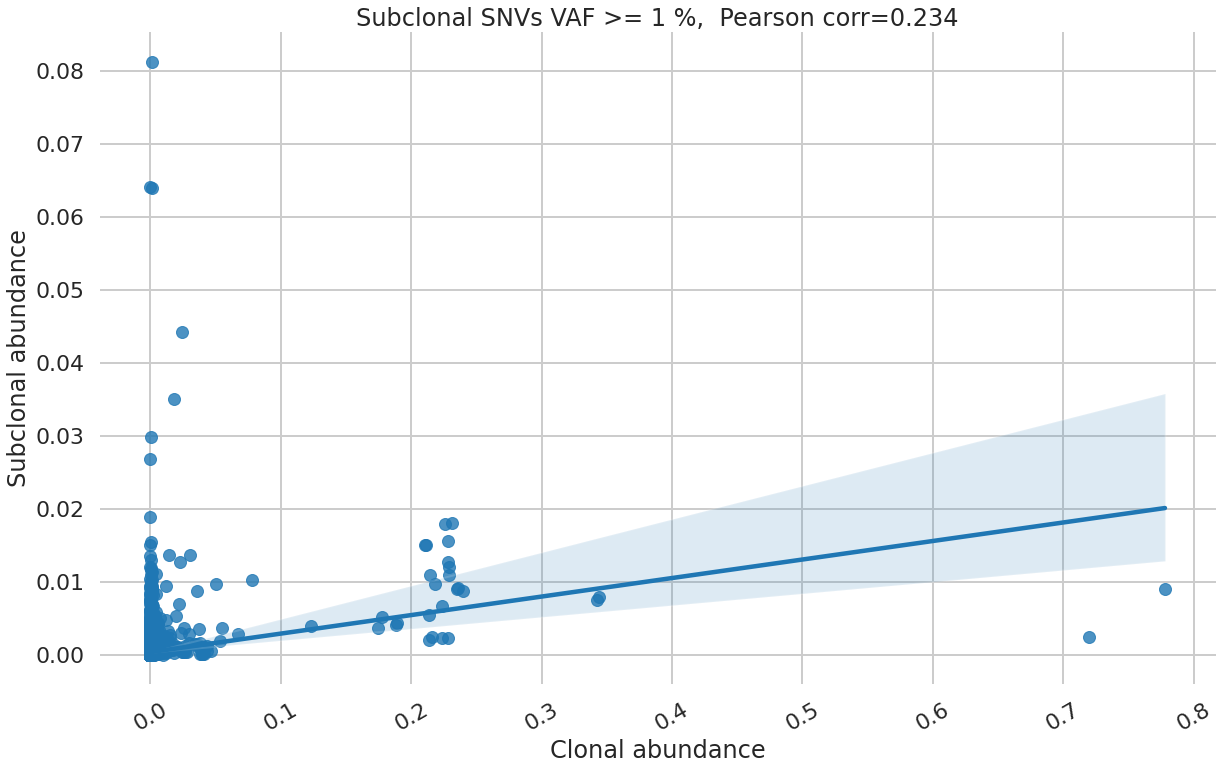

In [143]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf001), 
                 title="Subclonal SNVs VAF >= 1 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_1.png"), dpi=600)

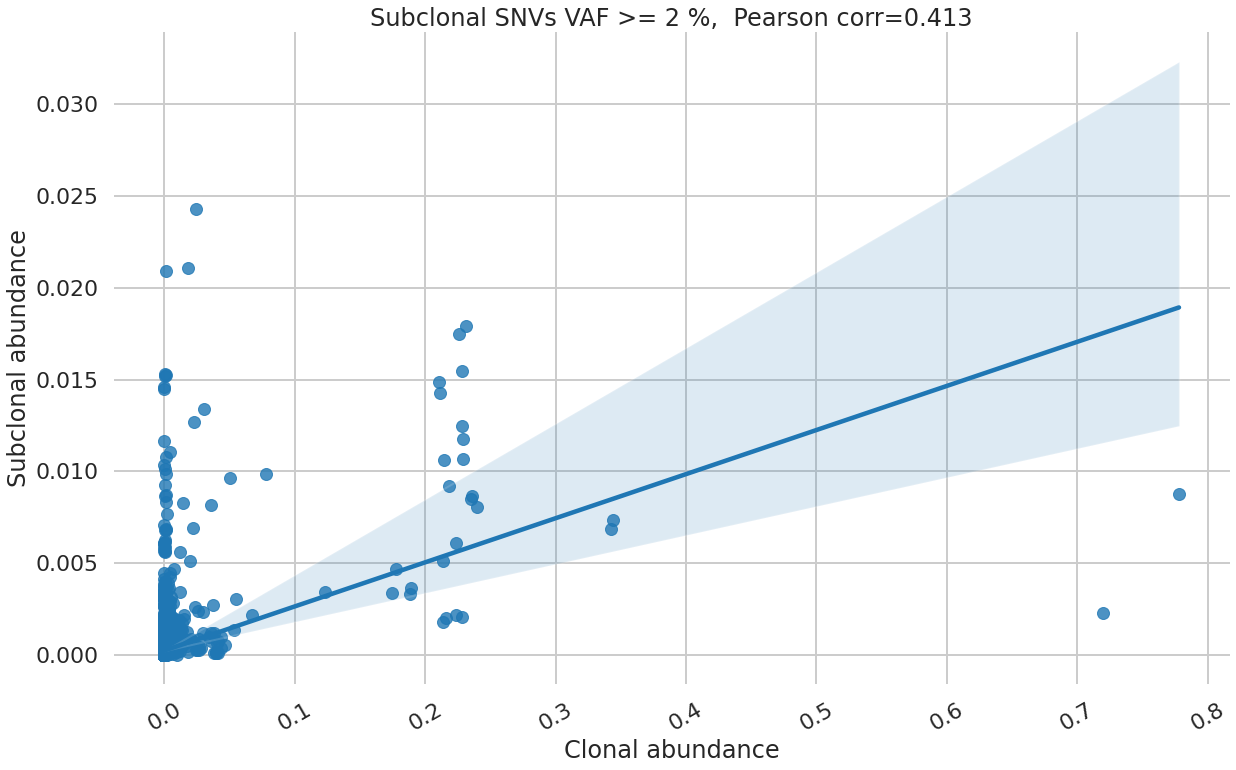

In [144]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf002), 
                 title="Subclonal SNVs VAF >= 2 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_2.png"), dpi=600)

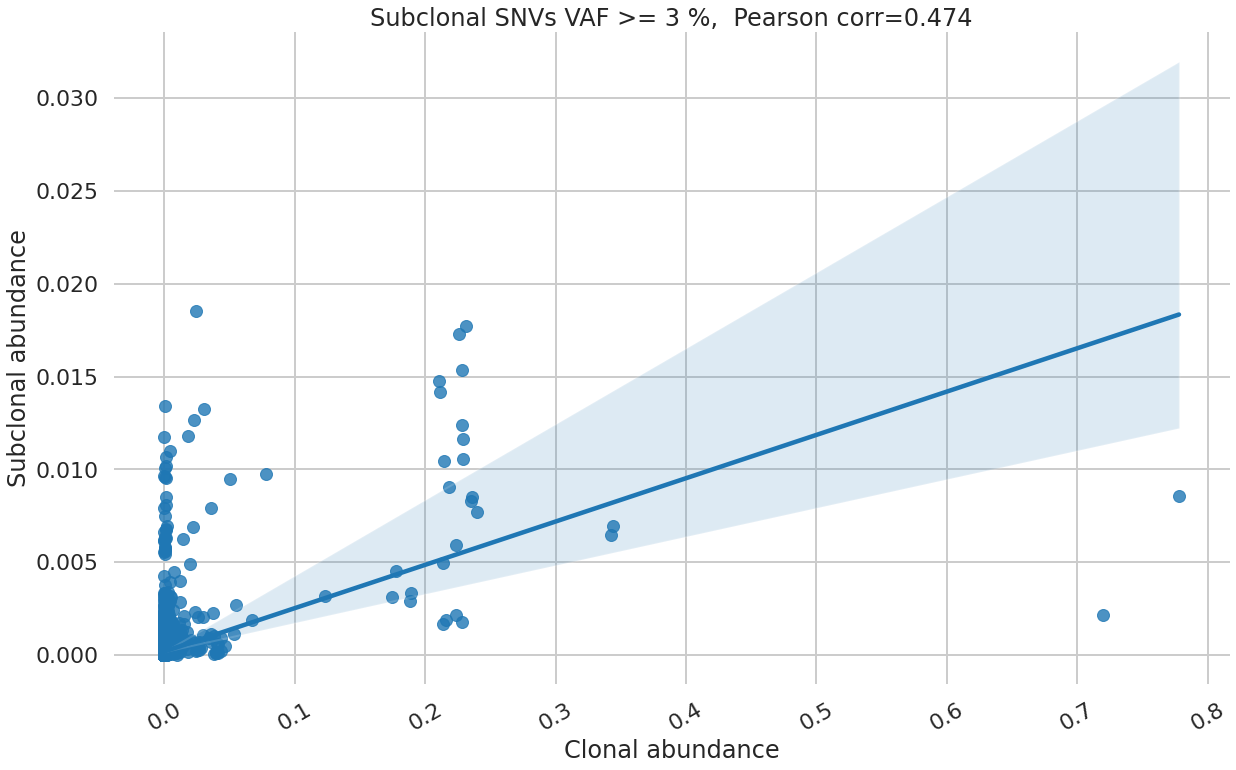

In [145]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf003), 
                 title="Subclonal SNVs VAF >= 3 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_3.png"), dpi=600)

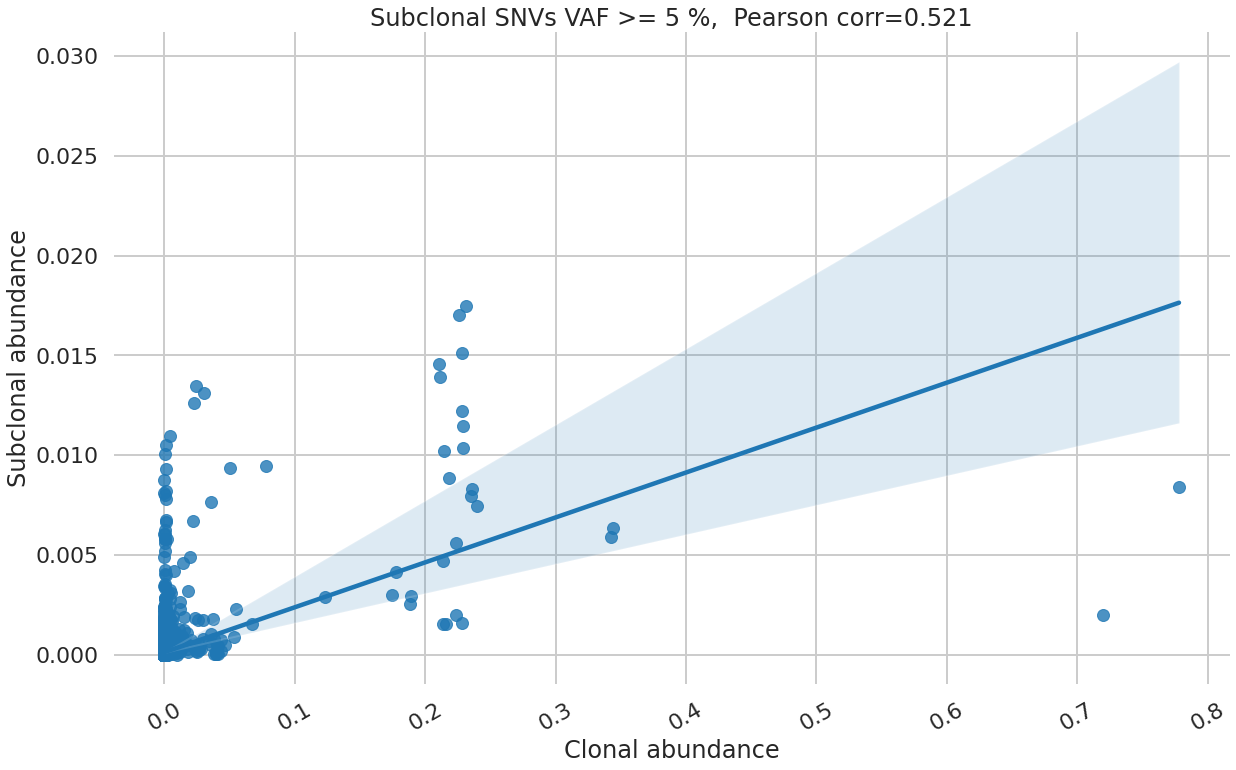

In [146]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf005), 
                 title="Subclonal SNVs VAF >= 5 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_5.png"), dpi=600)

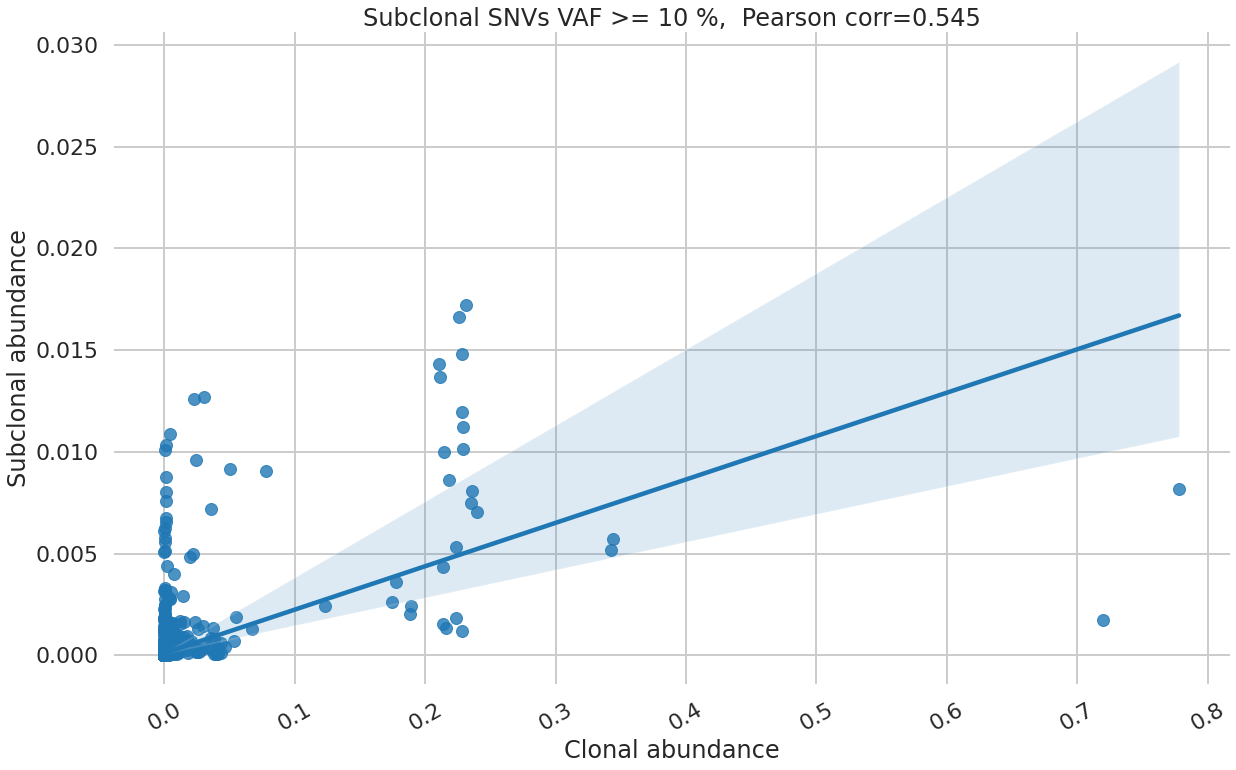

In [147]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf01), 
                 title="Subclonal SNVs VAF >= 10 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_10.png"), dpi=600)

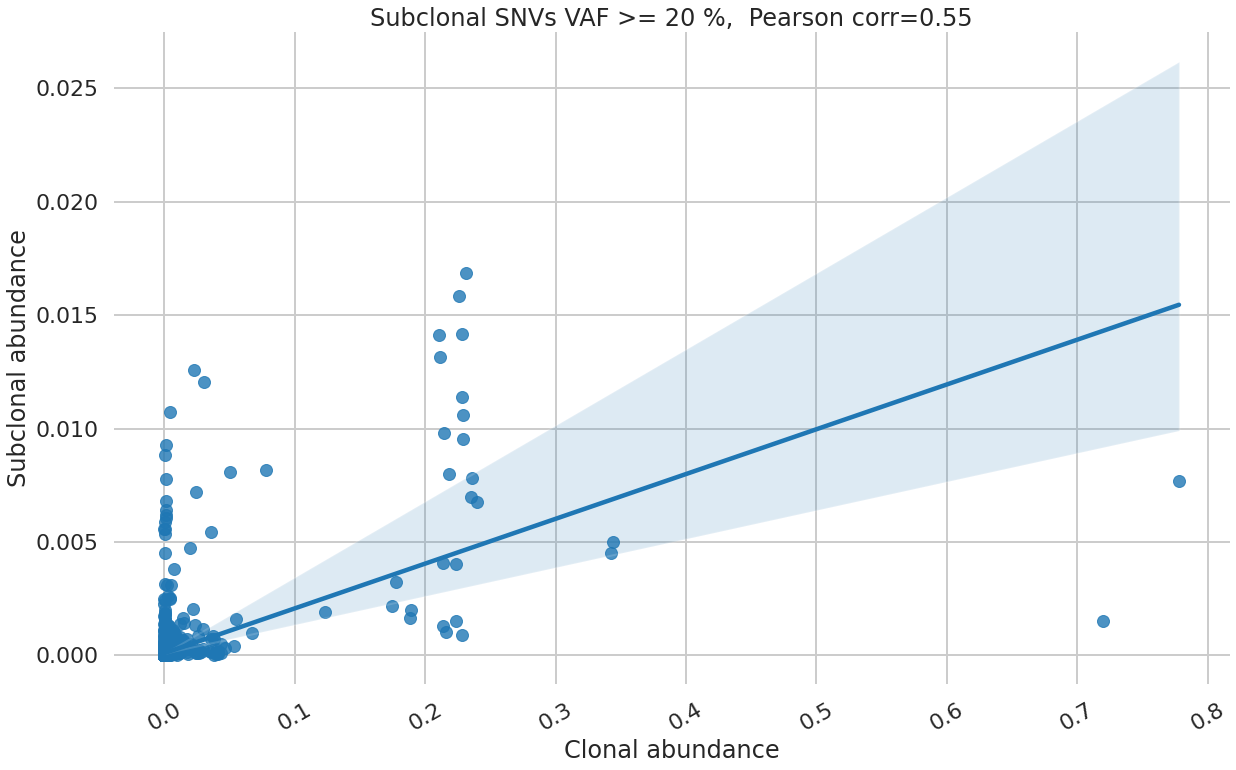

In [148]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf02), 
                 title="Subclonal SNVs VAF >= 20 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_20.png"), dpi=600)

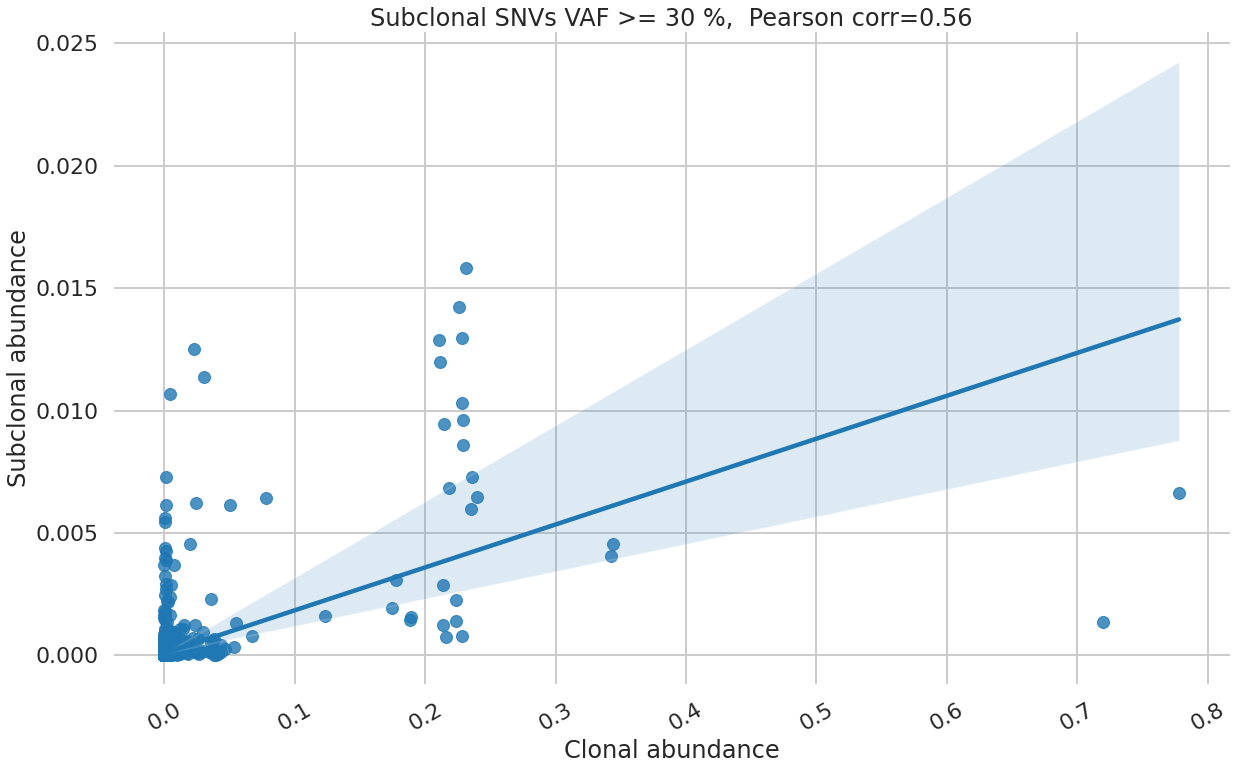

In [149]:
fig = plot_correlation(sample_data=sample_ena_filtered_samples, 
                 clonal_data=filter_out_synonymous_variants(clonal_snvs), 
                 subclonal_data=filter_out_synonymous_variants(subclonal_snvs_filtered_vaf03), 
                 title="Subclonal SNVs VAF >= 30 %, ")
fig.savefig(os.path.join(figure_output_folder, "figure_05_correlation_clonal_subclonal_af_vaf_30.png"), dpi=600)

## Correlation between clonal abundance and conservation

In [150]:
def plot_correlation_conservation(sample_data, clonal_data, title=None):
    
    included_samples = sample_data.run_accession.unique()
    frequencies_clonal_snvs = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "sample"]].groupby("variant_id").count().reset_index()
    frequencies_clonal_snvs["af"] = frequencies_clonal_snvs["sample"] / included_samples.shape[0]
    
    conservation_data = clonal_data[clonal_data["sample"].isin(included_samples)][["variant_id", "cons_hmm_sars_cov_2"]].groupby("variant_id").first().reset_index()
    
    data = pd.merge(left=frequencies_clonal_snvs, right=conservation_data, on="variant_id", how="left")
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 12))
    sns.regplot(data=data, x="af", y="cons_hmm_sars_cov_2")
    plt.xticks(rotation=30)
    sns.despine(bottom=True, left=True)
    ax.set_xlabel("Clonal abundance")
    ax.set_ylabel("ConsHMM on SARS-CoV-2")
    plt.title("{} Pearson corr={}".format(title, round(data.corr().af[2], 3)))
    print(data.corr())
    return fig

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.019087
af                   1.000000  1.000000            -0.019087
cons_hmm_sars_cov_2 -0.019087 -0.019087             1.000000


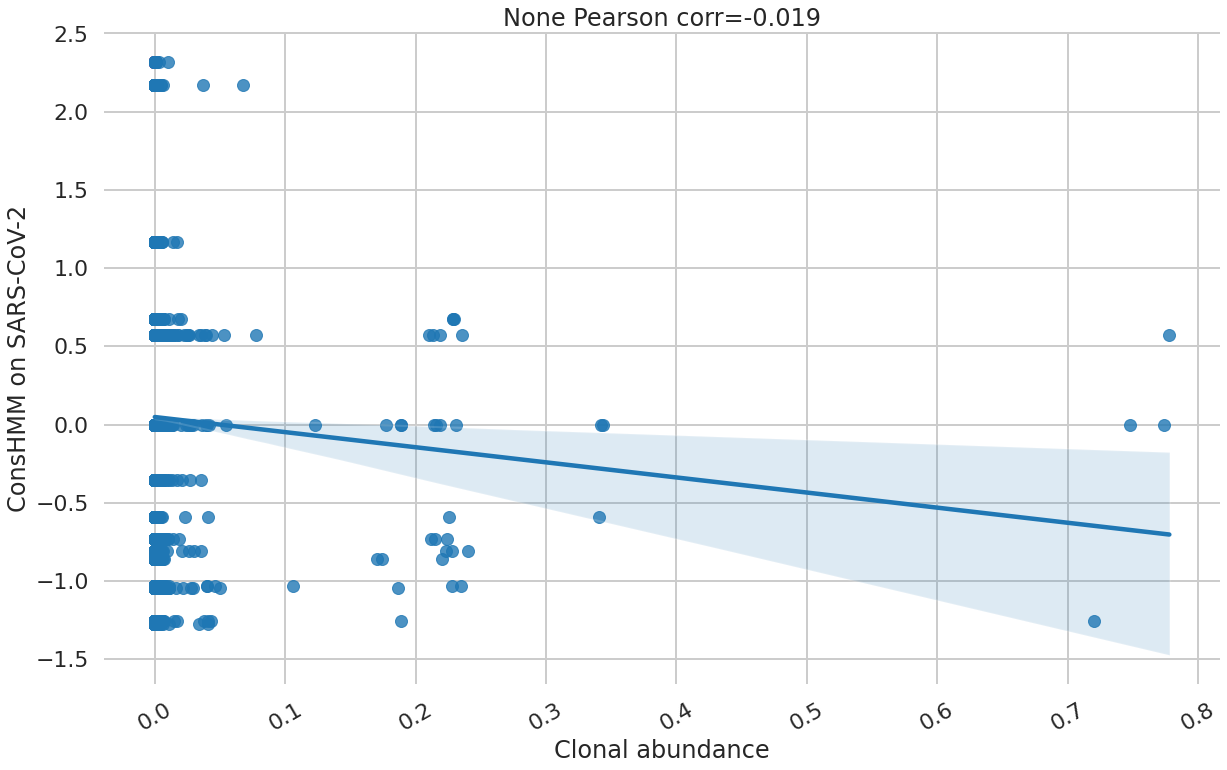

In [151]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=clonal_snvs)

                       sample        af  cons_hmm_sars_cov_2
sample               1.000000  1.000000            -0.036796
af                   1.000000  1.000000            -0.036796
cons_hmm_sars_cov_2 -0.036796 -0.036796             1.000000


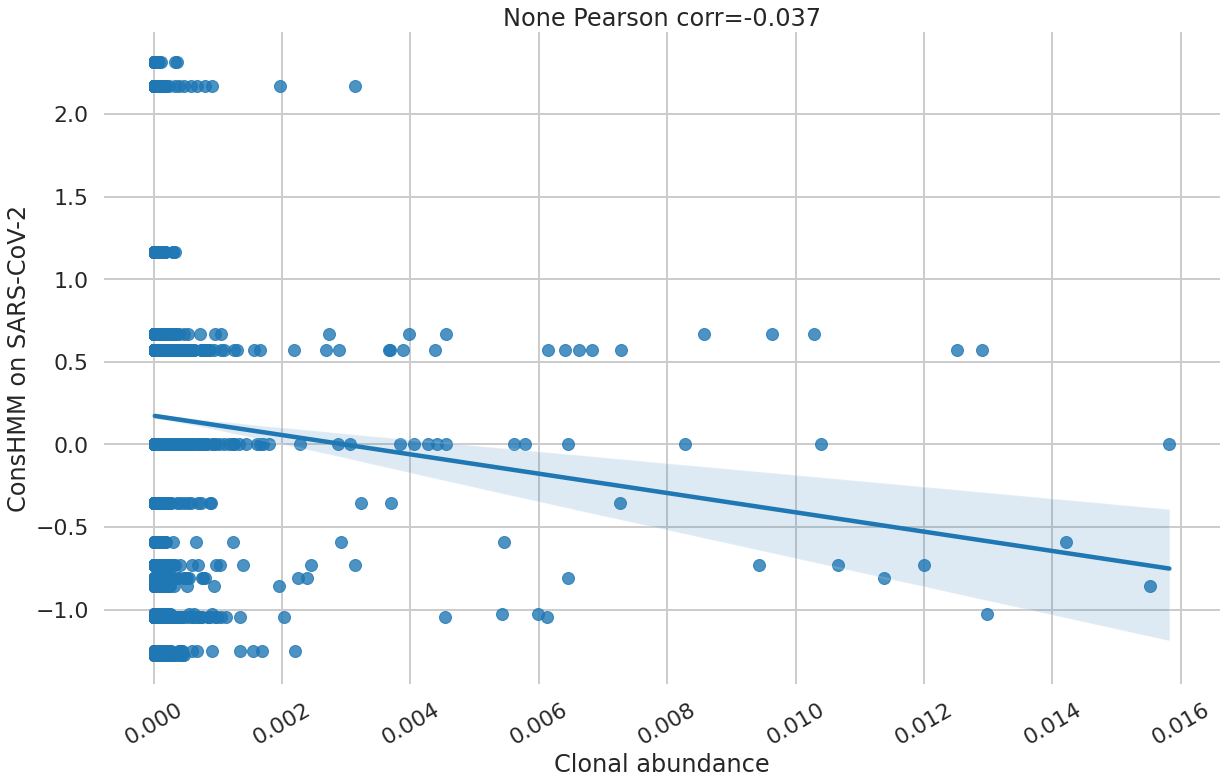

In [152]:
fig = plot_correlation_conservation(sample_data=sample_ena_filtered_samples, clonal_data=subclonal_snvs_filtered_vaf03)

In [153]:
clonal_snvs.shape

(912234, 35)

## Evolution from subclonal into clonal

In [154]:
def plot_upset(clonal_data, subclonal_data, month):
    data = pd.merge(left=clonal_data[clonal_data.month <= month][["variant_id", "clonal"]],
             right=subclonal_data[subclonal_data.month <= month][["variant_id", "subclonal"]],
             on="variant_id", how="outer").fillna(False)[["variant_id", "clonal", "subclonal"]].groupby("variant_id").sum().reset_index()
    data.clonal = data.clonal.astype(bool)
    data.subclonal = data.subclonal.astype(bool)
    data.set_index(["clonal", "subclonal"], inplace=True)
    #return data
    fig = plt.figure(figsize=(10,6))
    upset = UpSet(data, subset_size='auto', intersection_plot_elements=2, facecolor='steelblue', show_counts=True, element_size=80)
    upset.plot(fig=fig)
    plt.title("Until {}                                                                                                                 ".format(month))
    fig.savefig("clonal_subclonal_upset_until_{}.jpg".format(month), dpi=200)

In [155]:
def plot_subclonal_clonal_through_time(clonal_data, subclonal_data, samples_data, title=None):
    
    subclonal_data = add_dates_to_variants(variants=subclonal_data, samples=samples_data)
    clonal_data = add_dates_to_variants(variants=clonal_data, samples=samples_data)
    
    months = list(clonal_data.collection_date_month.sort_values().unique())
    only_clonal = []
    only_subclonal = []
    both = []
    
    for m in months:
        subclonal_variant_ids = set(subclonal_data[subclonal_data.collection_date_month <= m].variant_id.unique())
        clonal_variant_ids = set(clonal_data[clonal_data.collection_date_month <= m].variant_id.unique())
        both.append(len(subclonal_variant_ids.intersection(clonal_variant_ids)))
        only_clonal.append(len(clonal_variant_ids.difference(subclonal_variant_ids)))
        only_subclonal.append(len(subclonal_variant_ids.difference(clonal_variant_ids)))
    
    all_counts = [x + y + z for x, y, z in  zip(only_clonal, only_subclonal, both)] 
    
    
    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    sns.lineplot(x=pd.Series(months).astype(str), y=both, color=orange, label="Subclonal + clonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_clonal, color=lightblue, label="Only clonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=only_subclonal, color=green, label="Only subclonal", marker='o')
    sns.lineplot(x=pd.Series(months).astype(str), y=all_counts, color=grey, label="All", linestyle='--')
    plt.axhline(SARS_COV_2_GENOME_LENGTH * 3, linestyle='--', color=red, label="Max. number SNVs")
    plt.title(title)
    plt.xlabel(None)
    plt.ylabel("Number of unique mutations")
    plt.yscale('log')
    plt.xticks(rotation=30)
    plt.minorticks_on()
    sns.despine(bottom=True, left=True)
    ax.legend()
    #ax.grid(axis='x')
    ax.grid(axis='x', which='major', alpha=0.5, linewidth=0.5)
    ax.grid(axis='y', which='minor', alpha=0.5, linestyle='dashed', linewidth=0.5)
    #ax.yaxis.set_major_formatter(ScalarFormatter())
    #ax.ticklabel_format(style='plain', axis='y')
    plt.tight_layout()
    return fig

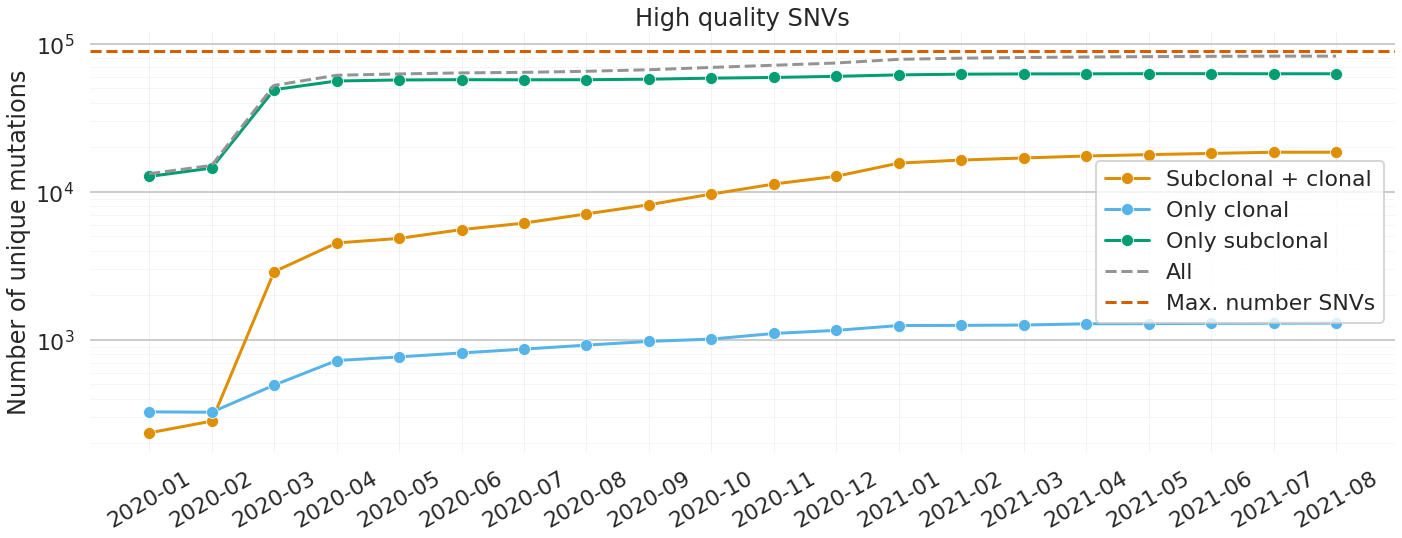

In [156]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs.png"), dpi=600)

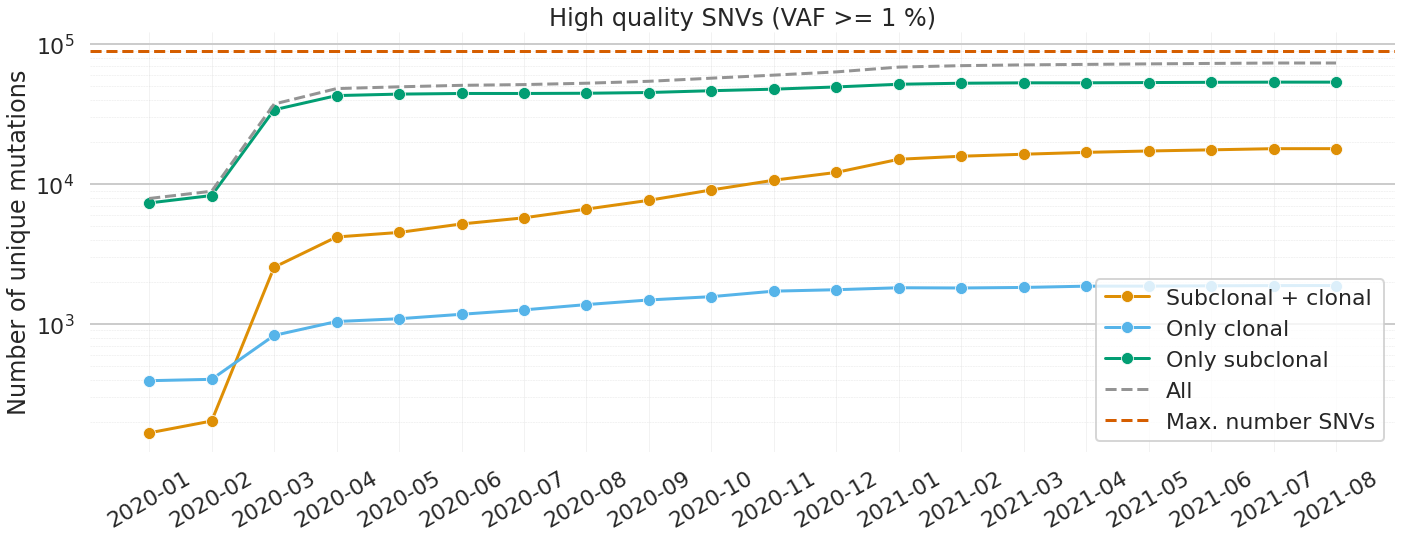

In [157]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_1.png"), dpi=600)

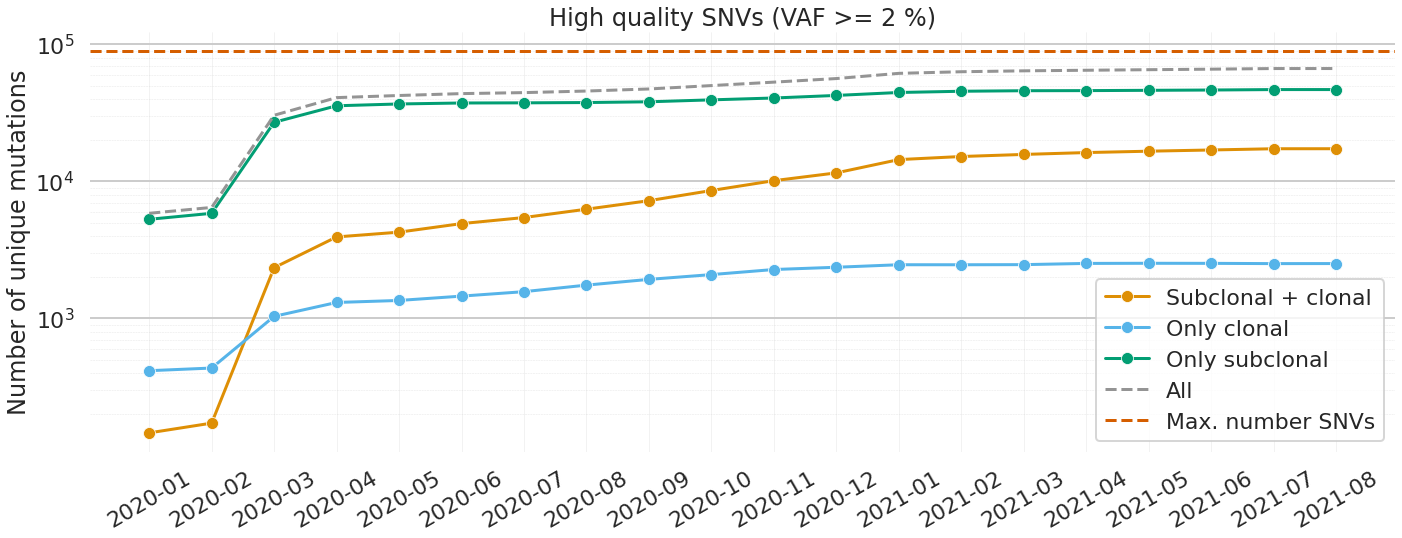

In [158]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_2.png"), dpi=600)

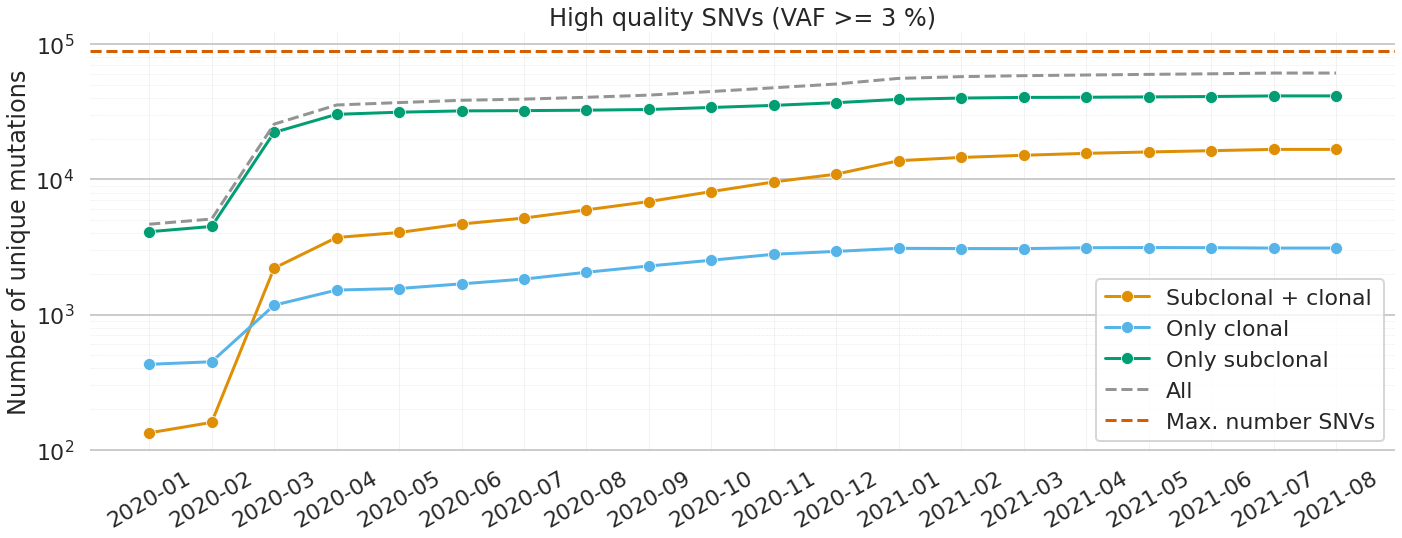

In [159]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_3.png"), dpi=600)

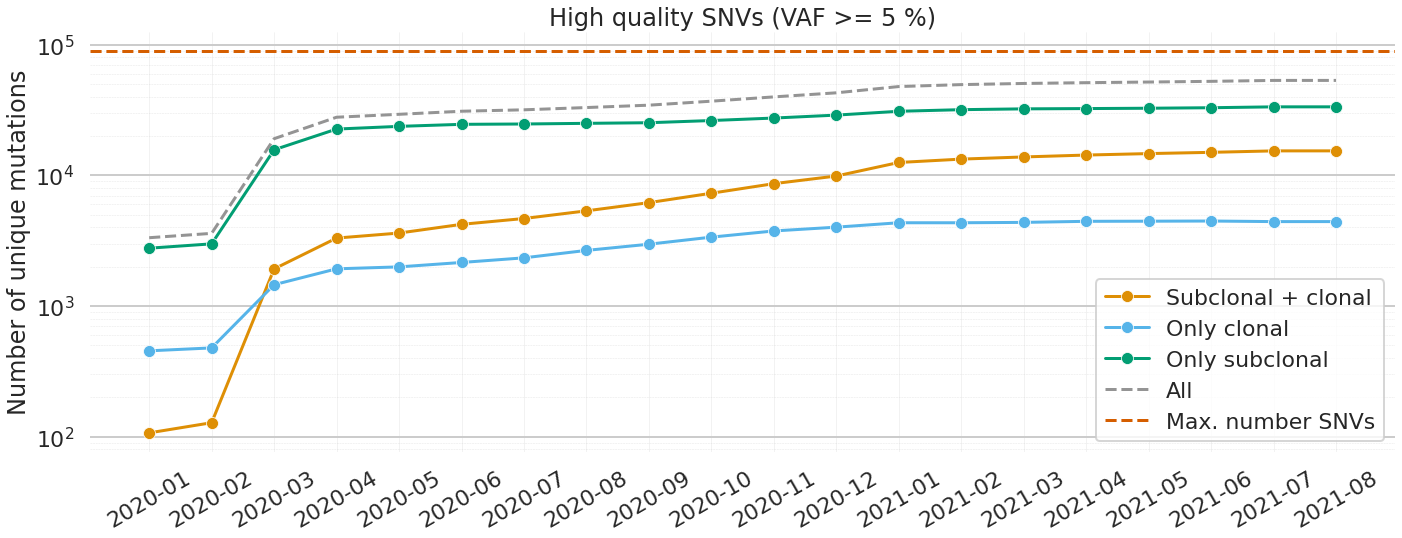

In [160]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_5.png"), dpi=600)

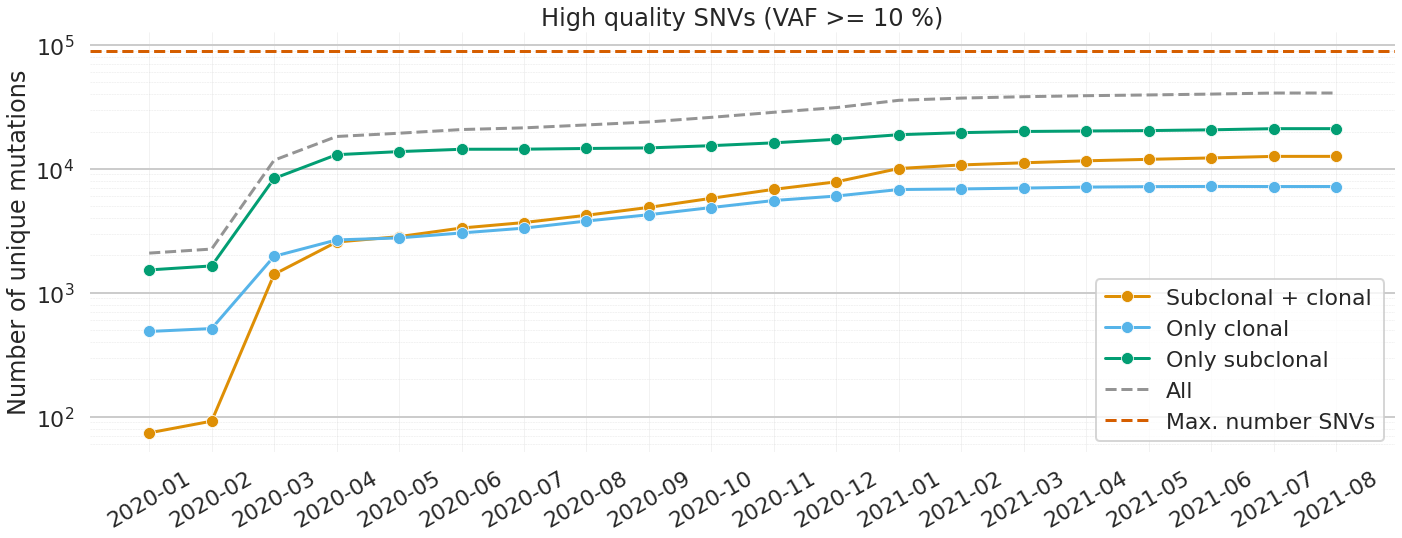

In [161]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_10.png"), dpi=600)

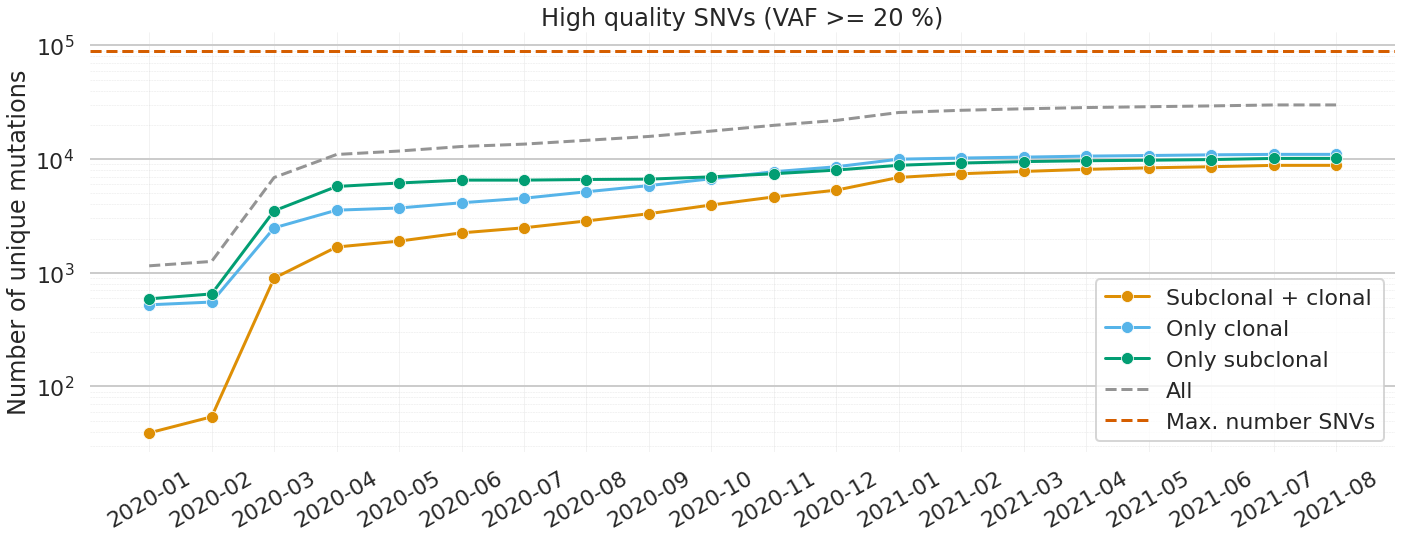

In [162]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_20.png"), dpi=600)

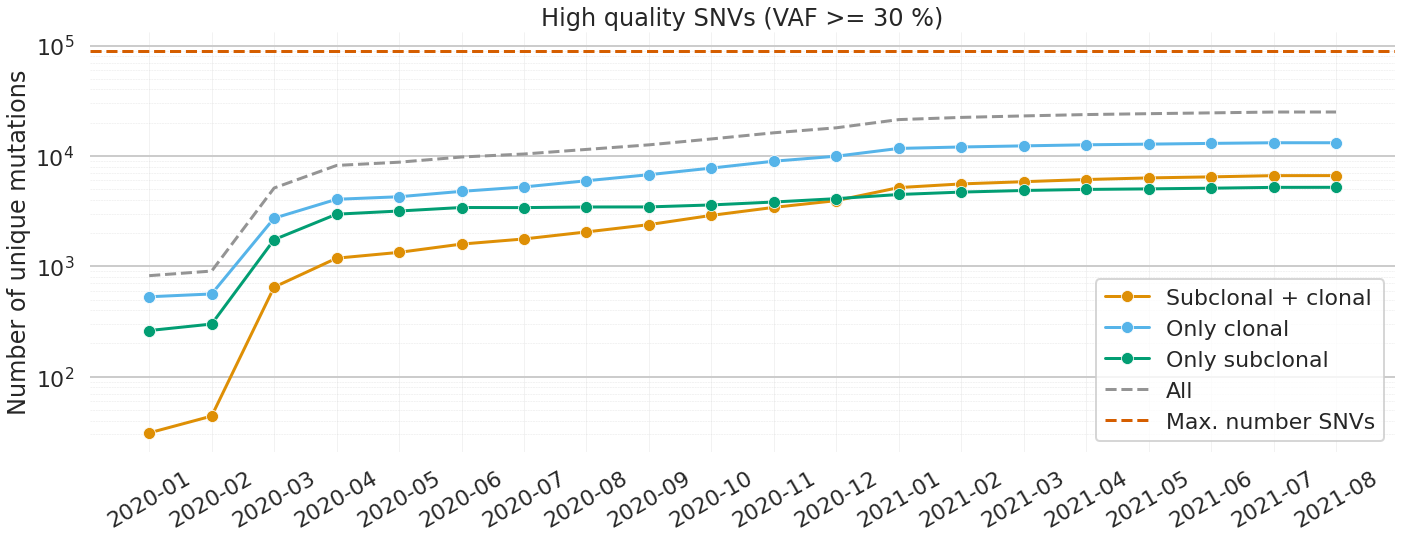

In [163]:
fig = plot_subclonal_clonal_through_time(
    clonal_data=clonal_variants, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    samples_data=sample_ena_filtered_samples, 
    title="High quality SNVs (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_06_evolution_subclonal_into_clonal_snvs_vaf_30.png"), dpi=600)

## Time from subclonal to clonal

Here we aim to confirm if subclonal observations occur before clonal observations. For that purpose we look into those variants which have both clonal and subclonal observations and then look at the time between the first clonal observation and the first subclonal observation. We expect to see a trend that grows with the passing of time as subclonal observations accumulate. 

Depending on the filtering criteria applied on the subclonal dataset, the mutation space for SARS-CoV-2 is saturated very quickly, meaning that all possible mutations are in the subclonal dataset and thus virtually all clonal variants are previously observed as subclonal. Thus we aim to confirm that the expected trend holds when the mutation space is not saturated. The RNA-Seq samples have a strong effect on the quick saturation of the mutation space, as those are more prevalent on the early months of the dataset and RNA-Seq shows a larger average number of mutations per sample.

In [164]:
def plot_subclonal_to_clonal_time(clonal_data, subclonal_data, sample_data, title=None):
    clonal_variant_ids = set(clonal_data.variant_id)
    subclonal_variant_ids = set(subclonal_data.variant_id)
    variants_of_interest = list(subclonal_variant_ids.intersection(clonal_variant_ids))
    print("There are {} variants with clonal and subclonal observations".format(len(variants_of_interest)))
    
    clonal_data_with_collection_date = add_dates_to_variants(variants=clonal_data, samples=sample_data)
    subclonal_data_with_collection_date = add_dates_to_variants(variants=subclonal_data, samples=sample_data)
    
    first_clonal_observations = clonal_data_with_collection_date[clonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_clonal_observation"})
    first_clonal_observations.first_clonal_observation = pd.to_datetime(first_clonal_observations.first_clonal_observation)
    
    first_subclonal_observations = subclonal_data_with_collection_date[subclonal_data_with_collection_date.variant_id.isin(variants_of_interest)][["variant_id", "collection_date"]]\
        .groupby("variant_id").min().reset_index().rename(columns={"collection_date": "first_subclonal_observation"})
    first_subclonal_observations.first_subclonal_observation = pd.to_datetime(first_subclonal_observations.first_subclonal_observation)
    
    first_clonal_subclonal_observations = pd.merge(left=first_clonal_observations, right=first_subclonal_observations, on="variant_id", how="inner")
    first_clonal_subclonal_observations["time_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.first_clonal_observation - first_clonal_subclonal_observations.first_subclonal_observation
    first_clonal_subclonal_observations["days_from_subclonal_to_clonal"] = first_clonal_subclonal_observations.time_from_subclonal_to_clonal.transform(lambda x: int(x.days))
    
    predictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal > 0]
    unpredictable = first_clonal_subclonal_observations[first_clonal_subclonal_observations.days_from_subclonal_to_clonal <= 0]
    predictable = predictable[predictable.first_clonal_observation > '2020-02']
    unpredictable = unpredictable[unpredictable.first_clonal_observation > '2020-02']
    
    predictable["first_subclonal_observation_month"] = predictable.first_subclonal_observation.dt.to_period('m')
    predictable["first_clonal_observation_month"] = predictable.first_clonal_observation.dt.to_period('m')
    unpredictable["first_subclonal_observation_month"] = unpredictable.first_subclonal_observation.dt.to_period('m')
    unpredictable["first_clonal_observation_month"] = unpredictable.first_clonal_observation.dt.to_period('m')
    
    predictable_counts_per_month = predictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    predictable_counts_per_month["class"] = "predictable"
    unpredictable_counts_per_month = unpredictable[["first_subclonal_observation_month", "variant_id"]] \
        .groupby("first_subclonal_observation_month").count().reset_index().rename(columns={"variant_id": "count"})
    unpredictable_counts_per_month["class"] = "unpredictable"

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12), gridspec_kw={'height_ratios': [2, 1]})
    sns.scatterplot(data=predictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=orange, alpha=0.7,
                    label="Predictable (n={})".format(predictable.shape[0]),
                    ax=ax1)
    sns.scatterplot(data=unpredictable, 
                    x="first_clonal_observation", 
                    y="days_from_subclonal_to_clonal", 
                    marker="x", color=grey, alpha=0.7,
                    label="Unpredictable (n={})".format(unpredictable.shape[0]),
                    ax=ax1)
    sbarplot = sns.barplot(data=pd.concat([predictable_counts_per_month, unpredictable_counts_per_month]).sort_values("first_subclonal_observation_month"), 
                y="count", x="first_subclonal_observation_month", hue="class",  ax=ax2, palette=[orange, grey])
    for p in sbarplot.patches:
        value = int(p.get_height()) if not math.isnan(p.get_height()) else 0
        sbarplot.annotate(value, (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 9), textcoords = 'offset points', size=10)
    
    ax1.tick_params(axis='x', labelrotation=30)
    ax2.tick_params(axis='x', labelrotation=30)
    ax1.set_title(title)
    sns.despine(bottom=True, left=True)
    ax1.grid(axis='y')
    ax1.yaxis.set_major_formatter(ScalarFormatter())
    ax1.ticklabel_format(style='plain', axis='y')
    ax1.legend(loc='lower right')
    ax2.legend().remove()
    ax1.set_xlabel("1st clonal observation")
    ax2.set_ylabel(None)
    ax2.set_xlabel("Abundance of 1st subclonal observations")
    ax1.set_ylabel("Days since 1st subclonal observation")
    ax2.set_yscale("log")
    
    fig.tight_layout()

    return fig

There are 19225 variants with clonal and subclonal observations


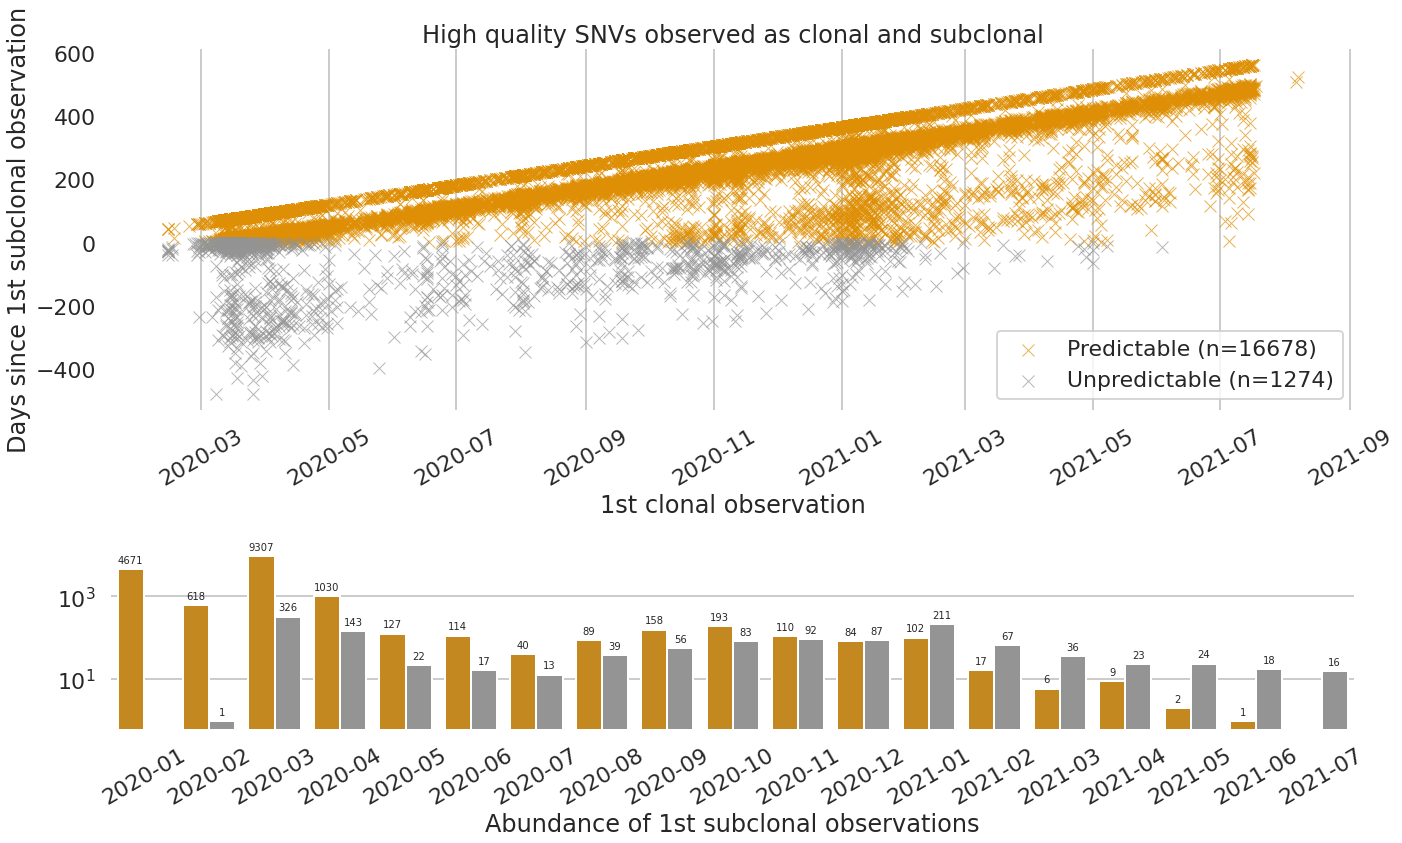

In [165]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf0_sr0, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs.png"), dpi=600)

There are 18613 variants with clonal and subclonal observations


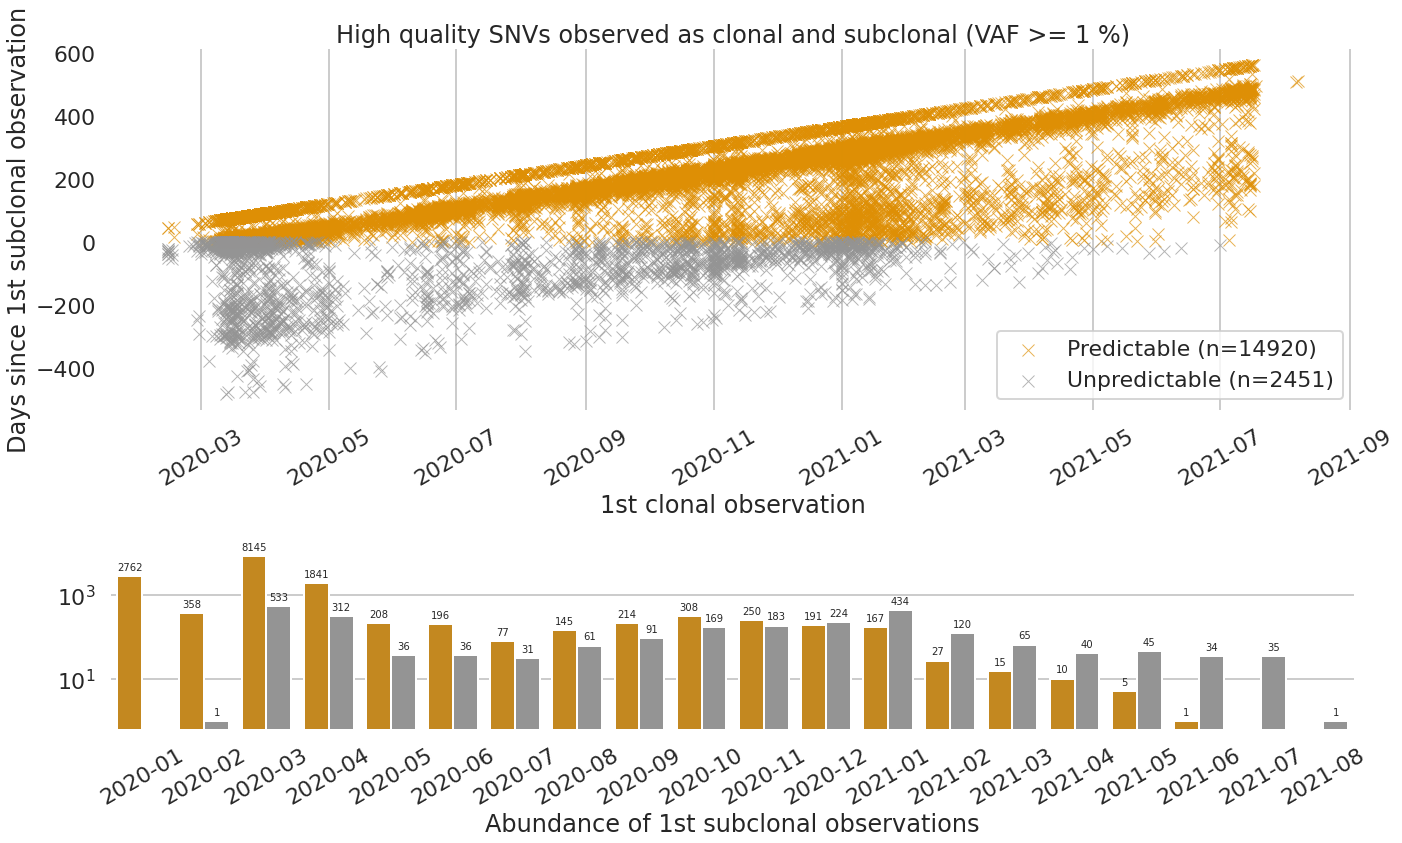

In [166]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 1 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_1.png"), dpi=600)

There are 17961 variants with clonal and subclonal observations


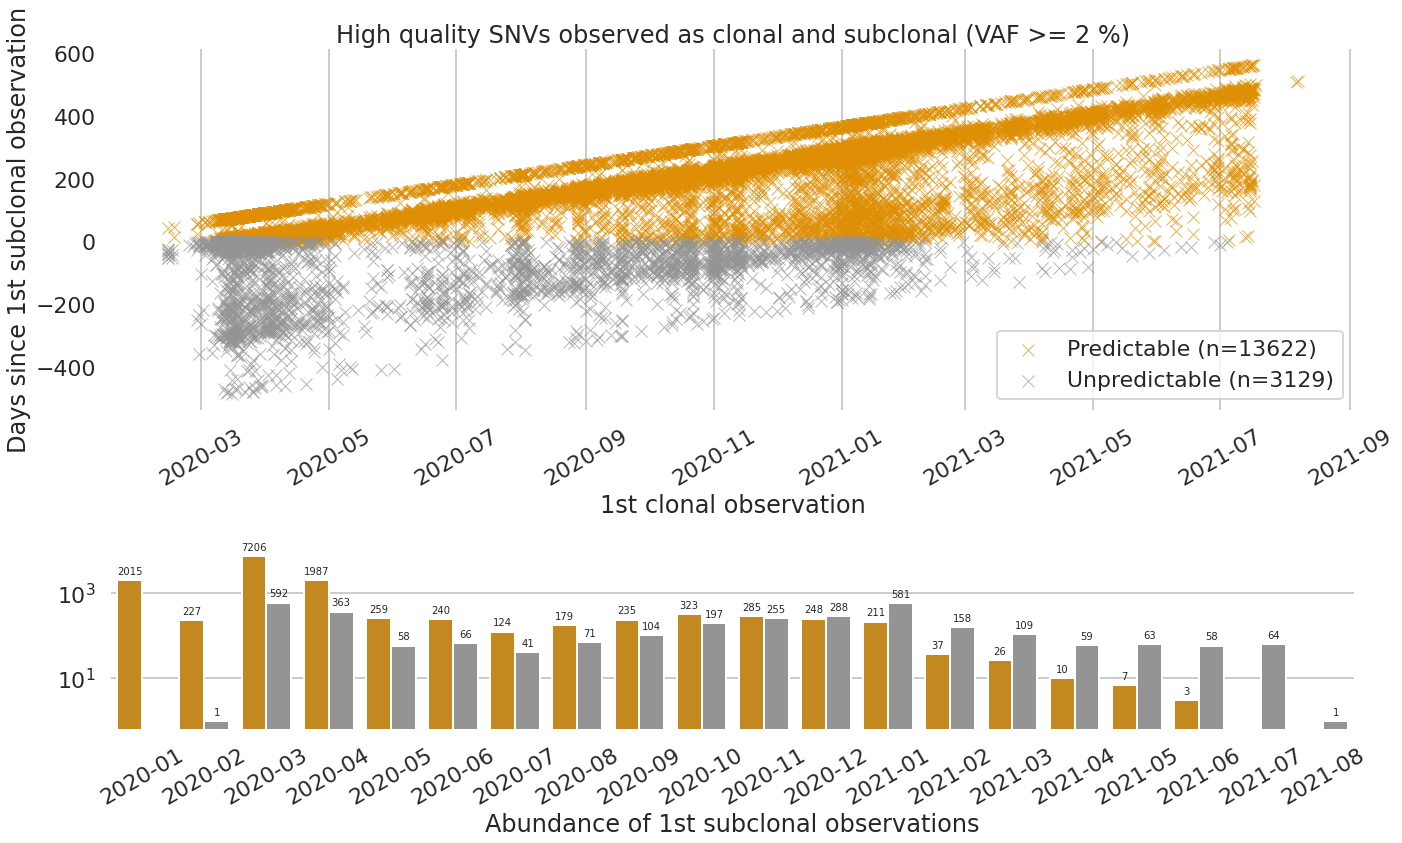

In [167]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 2 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_2.png"), dpi=600)

There are 17328 variants with clonal and subclonal observations


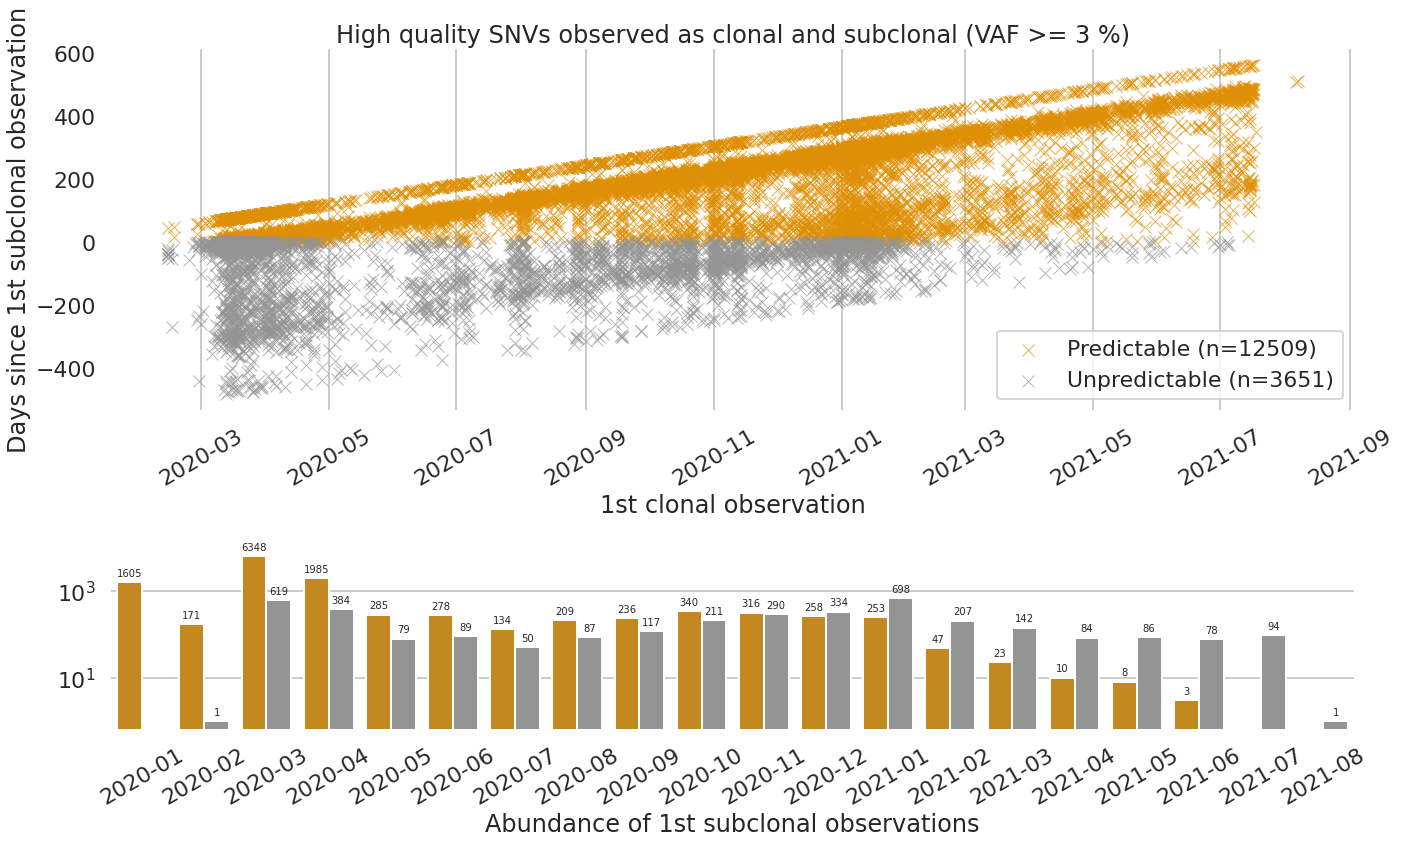

In [168]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 3 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_3.png"), dpi=600)

There are 15941 variants with clonal and subclonal observations


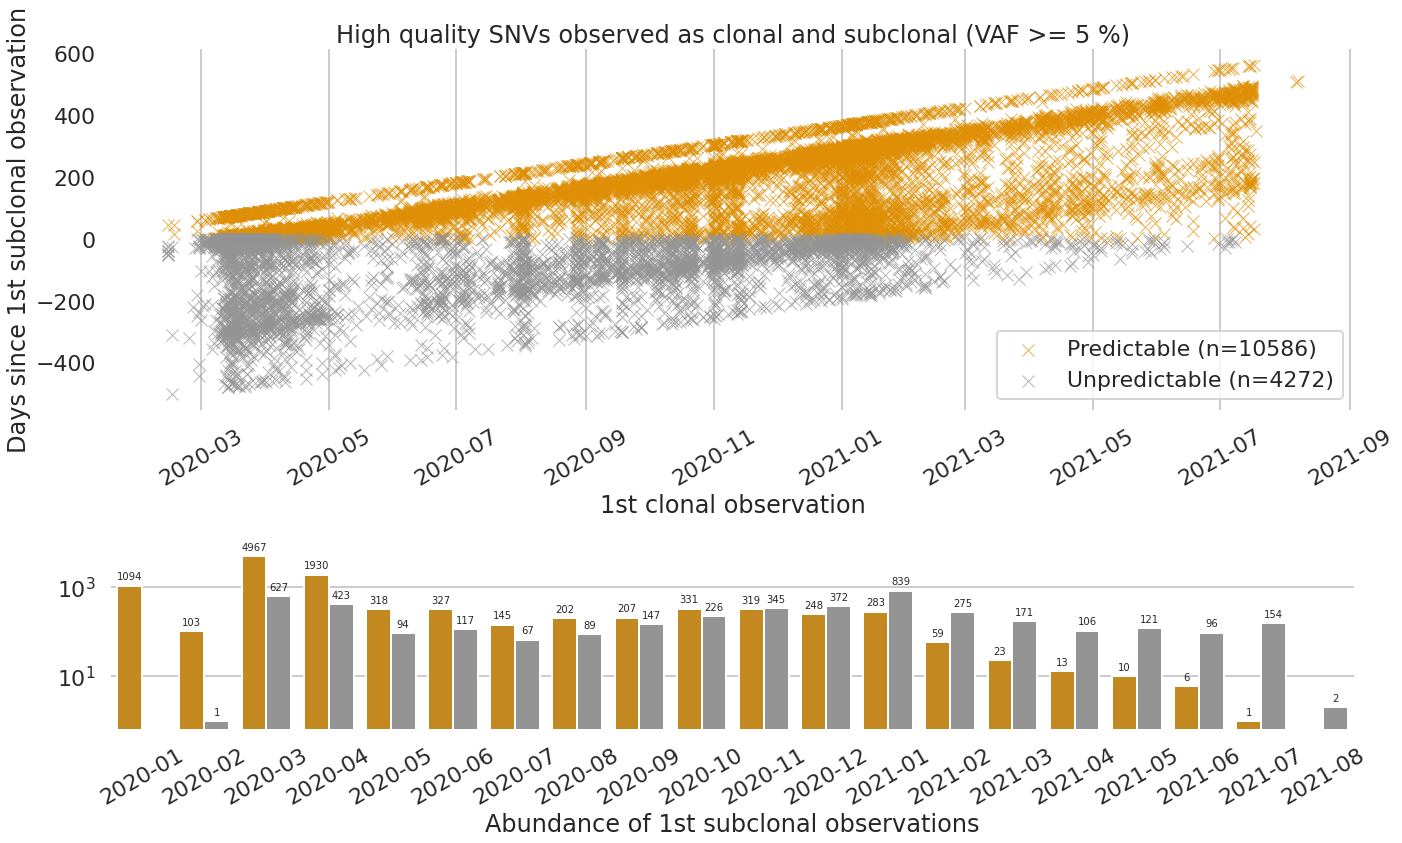

In [169]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 5 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_5.png"), dpi=600)

There are 13020 variants with clonal and subclonal observations


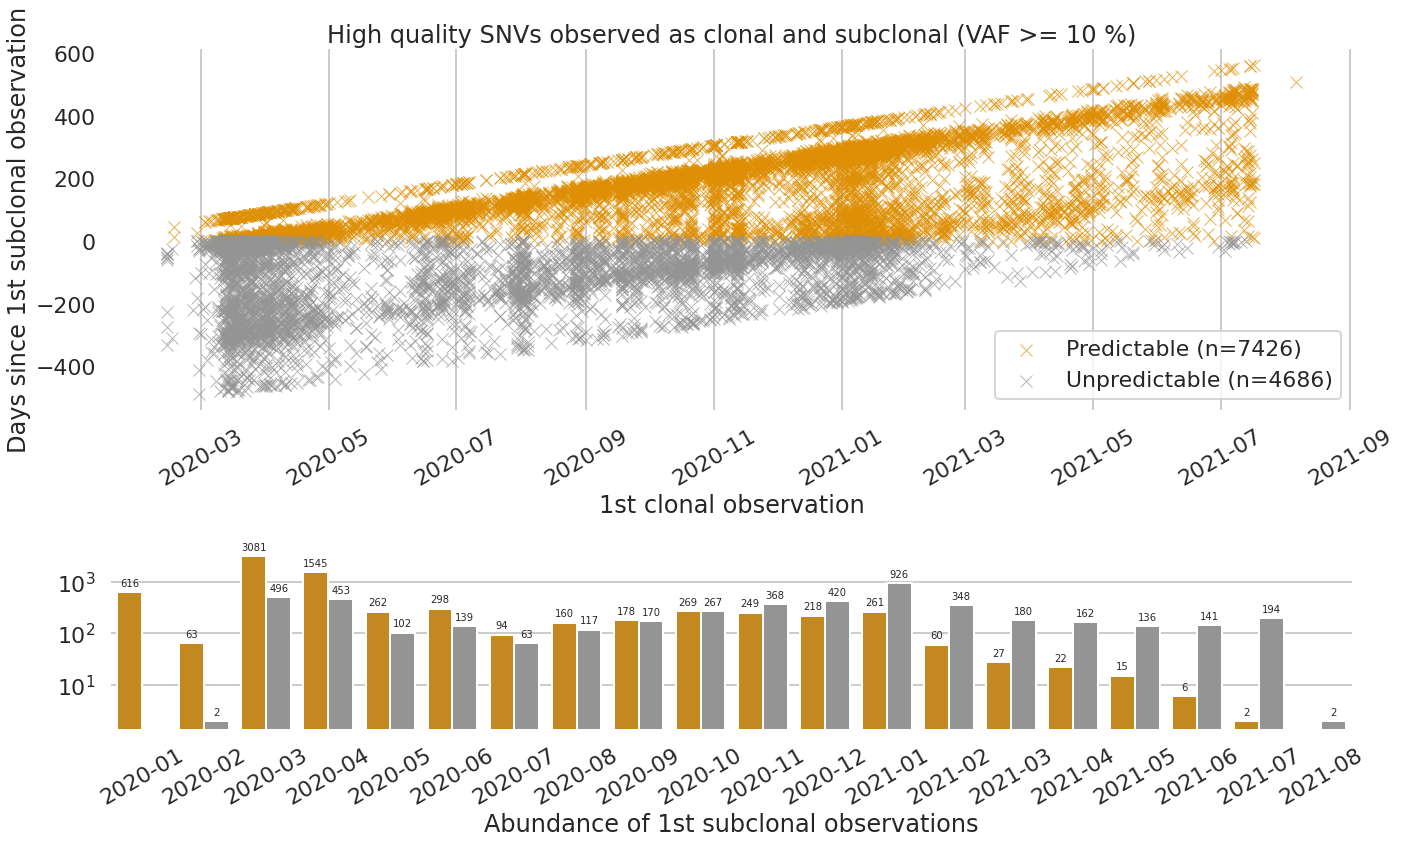

In [170]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 10 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_10.png"), dpi=600)

There are 9043 variants with clonal and subclonal observations


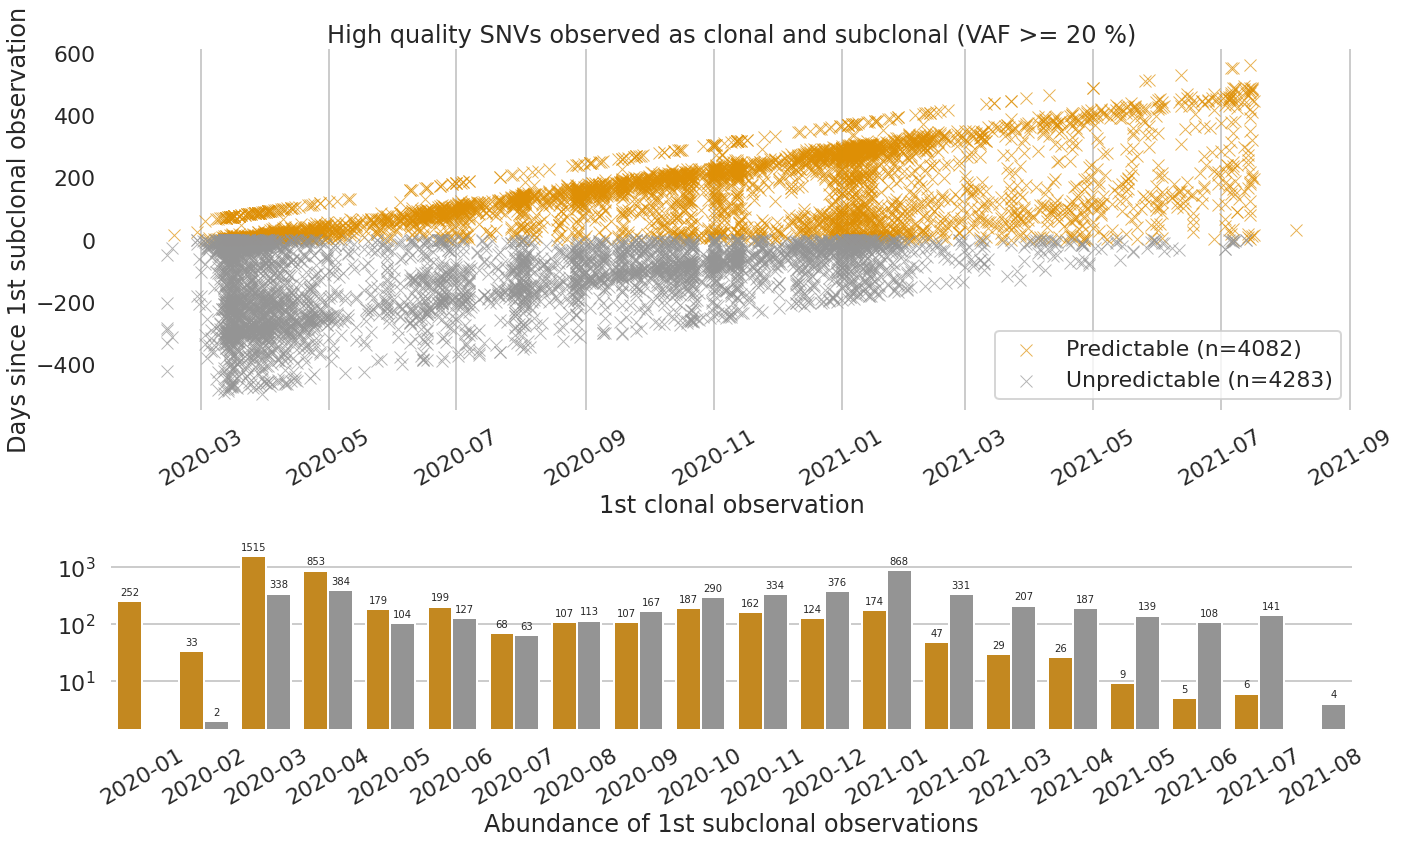

In [171]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 20 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_20.png"), dpi=600)

There are 6766 variants with clonal and subclonal observations


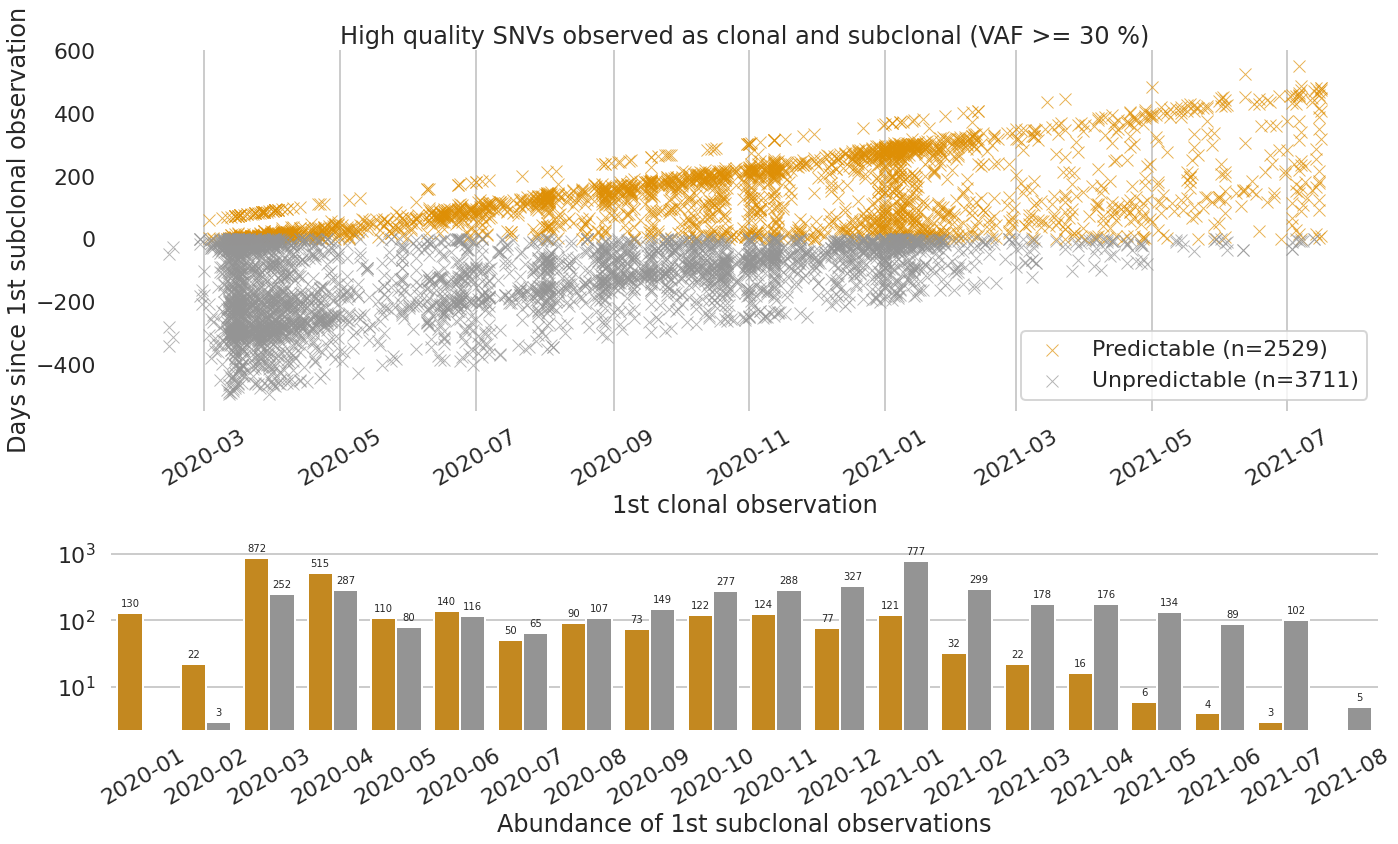

In [172]:
fig = plot_subclonal_to_clonal_time(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples,
    title="High quality SNVs observed as clonal and subclonal (VAF >= 30 %)")
fig.savefig(os.path.join(figure_output_folder, "figure_07_time_subclonal_into_clonal_snvs_vaf_30.png"), dpi=600)

## Prioritise subclonal variants

Here we aim at prioritising subclonal variants for their risk of becoming clonal.

### Simulation on accumulated temporal data

We have data accumulated since January 2020 until June 2021. Here we will use the data accumulated prior to January 2021 to prioritise variants only observed as subclonal. Then we will assess this prioritsation with the clonal variants that were first observed from January 2021 onwards.

We will use the dataset filtering out all subclonal variants with a VAF < 0.1 and with less than 3 supporting reads as its population AFs show the larger correlation with the clonal variants. RNA-seq samples are also excluded.

In [173]:
def select_test_and_truth_set(clonal_data, subclonal_data, sample_data):

    clonal_data_with_dates = add_dates_to_variants(clonal_data[
        (clonal_data.annotation_highest_impact != "synonymous_variant") & (~clonal_data.gene_name.isna())], sample_data)
    subclonal_data_with_dates = add_dates_to_variants(subclonal_data[
        (subclonal_data.annotation_highest_impact != "synonymous_variant") & (~subclonal_data.gene_name.isna())], sample_data)
    
    # gets only subclonal variants from 2020
    subclonal_2020 = subclonal_data_with_dates[subclonal_data_with_dates.collection_date < '2021-01-01']
    clonal_2020 = clonal_data_with_dates[clonal_data_with_dates.collection_date < '2021-01-01']
    only_subclonal_2020 = subclonal_2020[~subclonal_2020.variant_id.isin(clonal_2020.variant_id.unique())]
    
    # gets the new clonal variants from 2021
    clonal_first_observations = clonal_data_with_dates[["variant_id", "collection_date"]].groupby("variant_id").min().reset_index()
    clonal_2021_variant_ids = clonal_first_observations[clonal_first_observations.collection_date >= '2021-01-01'].variant_id.unique()
    clonal_2021 = clonal_data_with_dates[clonal_data_with_dates.variant_id.isin(clonal_2021_variant_ids)][["variant_id", "sample"]]
    
    print("Only subclonal from 2020: {}".format(only_subclonal_2020.variant_id.unique().shape[0]))
    print("New clonal from 2021: {}".format(clonal_2021.variant_id.unique().shape[0]))
    print("Predictable: {}".format(len(set(clonal_2021.variant_id).intersection(set(only_subclonal_2020.variant_id)))))
    
    return only_subclonal_2020, clonal_2021

In [174]:
def prioritise_subclonal(subclonal_data, clonal_data):
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    prioritised_subclonal = pd.merge(left=subclonal_counts, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("count_subclonal", ascending=False).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [175]:
only_subclonal_2020_vaf001, clonal_2021_vaf001 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf001, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf002, clonal_2021_vaf002 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf002, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf003, clonal_2021_vaf003 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf003, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf005, clonal_2021_vaf005 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf005, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf01, clonal_2021_vaf01 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf01, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf02, clonal_2021_vaf02 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf02, 
    sample_data=sample_ena_filtered_samples)
only_subclonal_2020_vaf03, clonal_2021_vaf03 = select_test_and_truth_set(
    clonal_data=clonal_snvs, 
    subclonal_data=subclonal_snvs_filtered_vaf03, 
    sample_data=sample_ena_filtered_samples)

Only subclonal from 2020: 38158
New clonal from 2021: 3712
Predictable: 3112
Only subclonal from 2020: 32480
New clonal from 2021: 3712
Predictable: 2826
Only subclonal from 2020: 28307
New clonal from 2021: 3712
Predictable: 2570
Only subclonal from 2020: 21985
New clonal from 2021: 3712
Predictable: 2148
Only subclonal from 2020: 13075
New clonal from 2021: 3712
Predictable: 1455
Only subclonal from 2020: 5962
New clonal from 2021: 3712
Predictable: 737
Only subclonal from 2020: 2990
New clonal from 2021: 3712
Predictable: 446


In [176]:
prioritised_subclonal_vaf001 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_vaf002 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_vaf003 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_vaf005 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_vaf01 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_vaf02 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_vaf03 = prioritise_subclonal(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [177]:
def reset_rank_column(data):
    del data["rank"]
    del data["index"]
    data.reset_index(drop=True, inplace=True)
    data.reset_index(inplace=True)
    data["rank"] = data["index"] + 1
    return data

def get_discounted_cumulative_gain(data, top=50, verbose=False):
    top_data = data.head(top)
    dcg = top_data[["match", "rank"]].apply(lambda x: ((2 ** int(x[0])) - 1) / (np.log2(x[1] + 1)), axis=1).sum()
    if verbose:
        print("matches={}, ranks={}".format(top_data.match.sum(), list(top_data[top_data.match]["rank"])))
        print("DCG={}".format(round(dcg, 3)))
    return dcg

def get_ideal_discounted_cumulative_gain(data, top=50):
    ideal_data = reset_rank_column(data=data.sort_values("count_clonal", ascending=False))
    return get_discounted_cumulative_gain(data=ideal_data, top=top)

def get_normalized_discounted_cumulative_gain(data, top=50, verbose=False, shuffles=100):
    dcg = get_discounted_cumulative_gain(data=data, top=top, verbose=True)
    ndcg = dcg / get_ideal_discounted_cumulative_gain(data=data, top=top)
    print("nDCG={}".format(round(ndcg, 3)))
    
    
    random_dcgs = []
    random_ndcgs = []
    random_matches = []
    for _ in range(shuffles):
        shuffled = shuffle_order(data)
        random_dcg = get_discounted_cumulative_gain(data=shuffled, top=top, verbose=verbose)
        random_ndcg = random_dcg / get_ideal_discounted_cumulative_gain(data=shuffled, top=top)
        random_dcgs.append(random_dcg)
        random_ndcgs.append(random_ndcg)
        random_matches.append(shuffled.head(top).match.sum())

    print("Random sort (n={n}) median DCG={dcg}, uDCG={udcg}, matches={matches}, max uDCG={max_udcg}, matches={max_matches}".format(
        dcg=round(np.median(random_dcgs), 3), udcg=round(np.median(random_ndcgs), 3), matches=np.median(random_matches), 
        max_udcg=round(np.max(random_ndcgs), 3), max_matches=np.max(random_matches),
        n=shuffles))
    
    return dcg, ndcg

In [178]:
def shuffle_order(data):
    random_prioritised_subclonal_2020 = data.sample(frac=1)
    del random_prioritised_subclonal_2020["rank"]
    del random_prioritised_subclonal_2020["index"]
    random_prioritised_subclonal_2020.reset_index(drop=True)
    random_prioritised_subclonal_2020.reset_index(inplace=True)
    random_prioritised_subclonal_2020["rank"] = random_prioritised_subclonal_2020["index"] + 1
    return random_prioritised_subclonal_2020

In [179]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf001)

matches=4, ranks=[9, 37, 43, 45]
DCG=0.856
nDCG=0.066
Random sort (n=100) median DCG=0.297, uDCG=0.023, matches=4.0, max uDCG=0.058, matches=10


In [180]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf002)

matches=5, ranks=[5, 27, 36, 46, 48]
DCG=1.145
nDCG=0.089
Random sort (n=100) median DCG=0.305, uDCG=0.024, matches=4.0, max uDCG=0.059, matches=9


In [181]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf003)

matches=6, ranks=[6, 26, 33, 34, 48, 49]
DCG=1.313
nDCG=0.102
Random sort (n=100) median DCG=0.349, uDCG=0.027, matches=4.0, max uDCG=0.065, matches=11


In [182]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf005)

matches=7, ranks=[6, 18, 26, 27, 47, 48, 50]
DCG=1.543
nDCG=0.12
Random sort (n=100) median DCG=0.368, uDCG=0.029, matches=5.0, max uDCG=0.064, matches=9


In [183]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf01)

matches=6, ranks=[1, 17, 40, 42, 45, 46]
DCG=1.972
nDCG=0.153
Random sort (n=100) median DCG=0.497, uDCG=0.039, matches=6.0, max uDCG=0.087, matches=13


In [184]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf02)

matches=5, ranks=[2, 10, 29, 33, 37]
DCG=1.511
nDCG=0.117
Random sort (n=100) median DCG=0.568, uDCG=0.044, matches=6.0, max uDCG=0.113, matches=15


In [185]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=11, ranks=[1, 10, 20, 29, 31, 33, 38, 39, 40, 42, 49]
DCG=3.042
nDCG=0.236
Random sort (n=100) median DCG=0.74, uDCG=0.057, matches=7.0, max uDCG=0.109, matches=13


In [186]:
def prioritise_subclonal_by_conservation(subclonal_data, clonal_data):
    #subclonal_data_with_conservation = pd.merge(left=subclonal_data, right=subclonal_snvs[["variant_id", "cons_hmm_sars_cov_2"]], on="variant_id", how="left").reset_index()
    subclonal_counts = subclonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
    subclonal_counts_with_annotations = pd.merge(left=subclonal_counts, right=subclonal_data, on="variant_id", how="left").groupby("variant_id").first().reset_index()
    clonal_counts = clonal_data[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_clonal"})
    subclonal_counts_with_annotations["af_cons"] = subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
    prioritised_subclonal = pd.merge(left=subclonal_counts_with_annotations, right=clonal_counts, on="variant_id", how="left").reset_index().sort_values("af_cons", ascending=True).reset_index(drop=True)
    prioritised_subclonal["match"] = prioritised_subclonal.count_clonal > 0
    del prioritised_subclonal["index"]
    prioritised_subclonal.reset_index(inplace=True)
    prioritised_subclonal["rank"] = prioritised_subclonal["index"] + 1
    prioritised_subclonal.fillna(0, inplace=True)
    return prioritised_subclonal

In [187]:
prioritised_subclonal_by_conservation_vaf001 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf001, clonal_data=clonal_2021_vaf001)
prioritised_subclonal_by_conservation_vaf002 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf002, clonal_data=clonal_2021_vaf002)
prioritised_subclonal_by_conservation_vaf003 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf003, clonal_data=clonal_2021_vaf003)
prioritised_subclonal_by_conservation_vaf005 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf005, clonal_data=clonal_2021_vaf005)
prioritised_subclonal_by_conservation_vaf01 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf01, clonal_data=clonal_2021_vaf01)
prioritised_subclonal_by_conservation_vaf02 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf02, clonal_data=clonal_2021_vaf02)
prioritised_subclonal_by_conservation_vaf03 = prioritise_subclonal_by_conservation(subclonal_data=only_subclonal_2020_vaf03, clonal_data=clonal_2021_vaf03)

In [188]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf001)

matches=6, ranks=[8, 10, 16, 26, 44, 46]
DCG=1.422
nDCG=0.11
Random sort (n=100) median DCG=0.297, uDCG=0.023, matches=4.0, max uDCG=0.068, matches=12


In [189]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf002)

matches=8, ranks=[8, 9, 18, 37, 42, 43, 44, 46]
DCG=1.772
nDCG=0.137
Random sort (n=100) median DCG=0.356, uDCG=0.028, matches=5.0, max uDCG=0.065, matches=9


In [190]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf003)

matches=9, ranks=[7, 9, 28, 31, 33, 34, 45, 46, 50]
DCG=1.969
nDCG=0.153
Random sort (n=100) median DCG=0.365, uDCG=0.028, matches=4.5, max uDCG=0.075, matches=11


In [191]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf005)

matches=9, ranks=[5, 9, 18, 22, 31, 35, 42, 47, 50]
DCG=2.077
nDCG=0.161
Random sort (n=100) median DCG=0.388, uDCG=0.03, matches=5.0, max uDCG=0.06, matches=10


In [192]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf01)

matches=14, ranks=[4, 16, 17, 22, 23, 26, 30, 33, 34, 35, 36, 44, 47, 48]
DCG=3.083
nDCG=0.239
Random sort (n=100) median DCG=0.487, uDCG=0.038, matches=6.0, max uDCG=0.082, matches=11


In [193]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf02)

matches=12, ranks=[6, 12, 14, 15, 16, 21, 25, 34, 41, 44, 47, 48]
DCG=2.734
nDCG=0.212
Random sort (n=100) median DCG=0.564, uDCG=0.044, matches=6.0, max uDCG=0.106, matches=12


In [194]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)

matches=14, ranks=[5, 6, 7, 8, 10, 13, 14, 17, 18, 21, 25, 27, 30, 46]
DCG=3.702
nDCG=0.287
Random sort (n=100) median DCG=0.789, uDCG=0.061, matches=8.0, max uDCG=0.131, matches=14


In [195]:
prioritised_subclonal_by_conservation_vaf03.head(50)

index variant_id  count_subclonal       sample  cons_hmm_sars_cov_2  \
0       0  23607:G>T                5  SRR12749720             -1.02973   
1       1  21420:A>C               36   ERR6109504             -0.35633   
2       2   8771:A>G                3   ERR5737146             -1.04511   
3       3  19137:A>C                3  SRR12379661             -1.04511   
4       4  15369:A>T                3   ERR5218545             -1.04511   
5       5  23031:T>C                3  SRR12379995             -1.02973   
6       6  28099:C>T                4  SRR13204724             -0.80744   
7       7  28254:A>T                3   ERR5072990             -0.80744   
8       8  27765:C>G                2   ERR5397022             -1.27455   
9       9  21090:C>T                2   ERR5631854             -1.27455   
10     10  22646:G>C                2   ERR6336319             -1.27455   
11     11  29595:T>C                2  SRR12427336             -1.25436   
12     12  29586:C>T                2   ERR6336245             -1.25436   
13     13   8327:C>T                4  SRR12427107             -0.59191   
14     14  17376:A>G                2   ERR5497775             -1.04511   
15     15  19218:T>C                2   ERR5310928             -1.04511   
16     16   2430:A>G                2  SRR12427349             -1.04511   
17     17  14697:C>T                2   ERR5632329             -1.04511   
18     18  20445:T>A                2   ERR4388108             -1.04511   
19     19  18657:C>A                2  SRR12423640             -1.04511   
20     20  17418:G>T                2  SRR12423529             -1.04511   
21     21  15380:G>C                2   ERR6319024             -1.04511   
22     22  13695:A>G                2  SRR12427278             -1.04511   
23     23   3863:G>T                2   ERR4393799             -1.04511   
24     24  18465:T>C                2  SRR12379668             -1.04511   
25     25  29318:C>T                2   ERR6092069             -1.04511   
26     26  15909:T>C                2   ERR5494484             -1.04511   
27     27  13998:G>T                2  SRR12427323             -1.04511   
28     28  15744:C>T                2  SRR12423694             -1.04511   
29     29  25468:T>C                2   ERR6094845             -1.04511   
30     30   4829:C>T                2   ERR6090938             -1.04511   
31     31  14847:A>G                2   ERR5928933             -1.04511   
32     32  23606:C>T                2  SRR14095166             -1.02973   
33     33  23034:C>T                2   ERR5289784             -1.02973   
34     34   3290:C>G                2  SRR12316225             -1.02973   
35     35  23612:G>A                2   ERR6292745             -1.02973   
36     36   9721:T>A                3  SRR12379793             -0.59191   
37     37   4340:A>C                2  SRR12427041             -0.85561   
38     38  12355:G>T                2   ERR6092224             -0.85561   
39     39  21736:C>G                2   ERR6318730             -0.85561   
40     40   7211:T>A                2   ERR6092571             -0.85561   
41     41  27158:T>G                5  SRR13620184             -0.35633   
42     42   4067:G>A                2  SRR12423419             -0.80744   
43     43  27870:G>A                2  SRR12379592             -0.80744   
44     44   3181:A>C                2  SRR12427106             -0.80744   
45     45  22176:C>T                2   ERR6356728             -0.72927   
46     46   4028:C>T                2   ERR5064655             -0.72927   
47     47   1143:T>G                2   ERR5924684             -0.72927   
48     48   1956:A>G                2  SRR13879455             -0.72927   
49     49   2022:T>G                2  SRR12423230             -0.72927   

   gene_name         hgvs_p run_accession collection_date  \
0          S        p.R682L   SRR12749720      2020-08-04   
1     ORF1ab  p.*7052Sext*?    ERR6109504      2020-10-1

In [196]:
prioritised_subclonal_by_conservation_vaf03.head(50)[prioritised_subclonal_by_conservation_vaf03.gene_name == "S"][["variant_id", "hgvs_p", "gene_name", "cons_hmm_sars_cov_2", "count_subclonal", "count_clonal"]]

variant_id   hgvs_p gene_name  cons_hmm_sars_cov_2  count_subclonal  \
0   23607:G>T  p.R682L         S             -1.02973                5   
5   23031:T>C  p.F490S         S             -1.02973                3   
10  22646:G>C  p.V362L         S             -1.27455                2   
32  23606:C>T  p.R682W         S             -1.02973                2   
33  23034:C>T  p.P491L         S             -1.02973                2   
35  23612:G>A  p.A684T         S             -1.02973                2   
39  21736:C>G   p.F58L         S             -0.85561                2   
45  22176:C>T  p.S205F         S             -0.72927                2   

    count_clonal  
0            0.0  
5           52.0  
10           0.0  
32           0.0  
33           0.0  
35           0.0  
39           0.0  
45           1.0

In [197]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.L452Q"]

index variant_id  count_subclonal      sample  cons_hmm_sars_cov_2  \
522    522  22917:T>A                6  ERR5075255             -1.02973   

    gene_name   hgvs_p run_accession collection_date collection_date_month  \
522         S  p.L452Q    ERR5075255      2020-01-01               2020-01   

    collection_date_month_str   af_cons  count_clonal  match  rank  
522                   2020-01 -1.845028          39.0   True   523

In [198]:
prioritised_subclonal_by_conservation_vaf001[prioritised_subclonal_by_conservation_vaf001.hgvs_p == "p.G75V"]

Empty DataFrame
Columns: [index, variant_id, count_subclonal, sample, cons_hmm_sars_cov_2, gene_name, hgvs_p, run_accession, collection_date, collection_date_month, collection_date_month_str, af_cons, count_clonal, match, rank]
Index: []

In [199]:
dcg, ndcg = get_normalized_discounted_cumulative_gain(data=prioritised_subclonal_by_conservation_vaf03)  #get_ideal_discounted_cumulative_gain(data=prioritised_subclonal_vaf03)

matches=14, ranks=[5, 6, 7, 8, 10, 13, 14, 17, 18, 21, 25, 27, 30, 46]
DCG=3.702
nDCG=0.287
Random sort (n=100) median DCG=0.773, uDCG=0.06, matches=7.0, max uDCG=0.106, matches=13


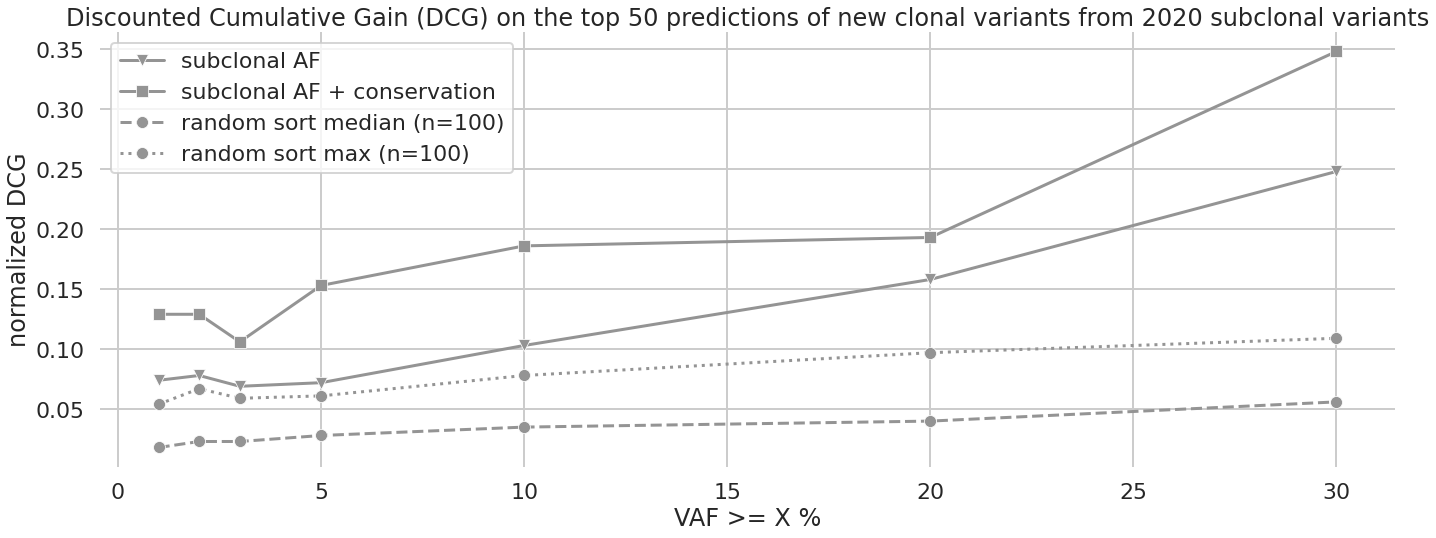

In [200]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "prioritization_by_subclonal_count":[0.074, 0.078, 0.069, 0.072, 0.103, 0.158, 0.248],
                     "prioritization_by_subclonal_count_and_conservation":[0.129, 0.129, 0.106, 0.153, 0.186, 0.193, 0.348],
                     "prioritization_random_median":[0.018, 0.023, 0.023, 0.028, 0.035, 0.04, 0.056],
                     "prioritization_random_max":[0.054, 0.067, 0.059, 0.061, 0.078, 0.097, 0.109]
                    })

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count", color=grey, label="subclonal AF", marker='v')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_by_subclonal_count_and_conservation", color=grey, label="subclonal AF + conservation", marker='s')
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', )
sns.lineplot(data=data, x="vaf_threshold", y="prioritization_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', )
#plt.axhline(1.0, linestyle='--', color=red, label="ideal (sort by clonal frequency)")
plt.title("Discounted Cumulative Gain (DCG) on the top 50 predictions of new clonal variants from 2020 subclonal variants")
plt.xlabel("VAF >= X %")
plt.ylabel("normalized DCG")
sns.despine(bottom=True, left=True)
ax.legend()
plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_ndcg.jpg"), dpi=200)

In [201]:
def get_percentage_clonal(data):
    return data[data.count_clonal > 0].shape[0] / data[data.count_clonal == 0].shape[0]

print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf001))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf002))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf003))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf005))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf01))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf02))
print(get_percentage_clonal(data=prioritised_subclonal_by_conservation_vaf03))

0.08879758032300406
0.09529911647669792
0.09985623810078875
0.1082825023945153
0.12521514629948366
0.14105263157894737
0.17531446540880502


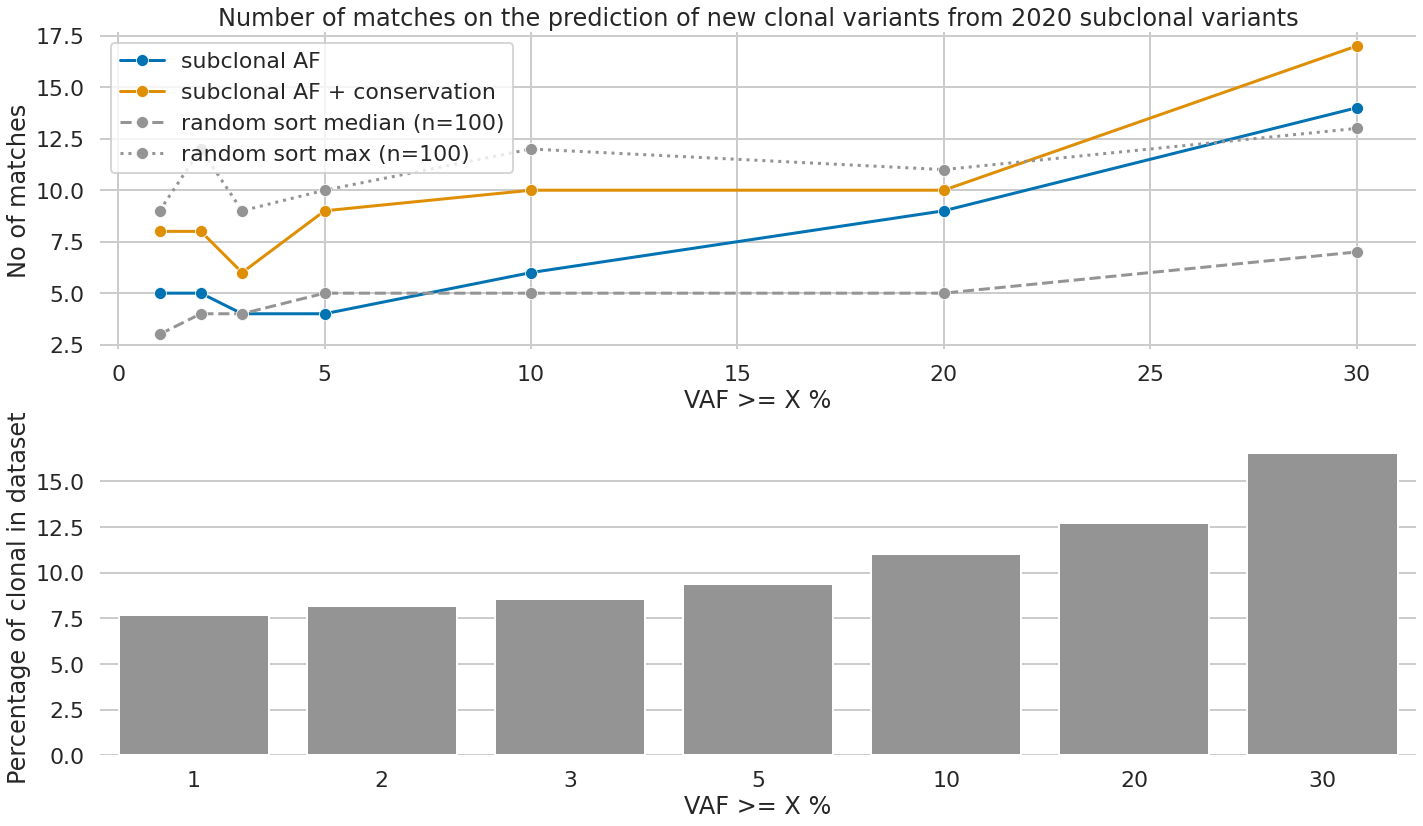

In [202]:
data = pd.DataFrame({"vaf_threshold":[1, 2, 3, 5, 10, 20, 30], 
                     "matches_by_subclonal_count":[5,5,4,4,6,9,14],
                     "matches_by_subclonal_count_and_conservation":[8,8,6,9,10,10,17],
                     "matches_random_median":[3,4,4,5,5,5,7],
                     "matches_random_max":[9,12,9,10,12,11,13],
                     "percent_clonal": [0.07680830747195035,0.08194740582800285,0.08579453922095089,0.09396302557670284,
                                        0.11007138722747443,0.127136021872864,0.16535819430814525]
                    })
data["percent_clonal"] =  data["percent_clonal"].transform(lambda x: round(x*100, 3))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count", color=blue, label="subclonal AF", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_by_subclonal_count_and_conservation", color=orange, label="subclonal AF + conservation", marker='o', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_median", color=grey, label="random sort median (n=100)", marker='o', linestyle='--', ax=ax1)
sns.lineplot(data=data, x="vaf_threshold", y="matches_random_max", color=grey, label="random sort max (n=100)", marker='o', linestyle='dotted', ax=ax1)
ax1.set_title("Number of matches on the prediction of new clonal variants from 2020 subclonal variants")
ax1.set_xlabel("VAF >= X %")
ax1.set_ylabel("No of matches")
sns.despine(bottom=True, left=True)
ax1.legend()

sns.barplot(data=data, x="vaf_threshold", y="percent_clonal", color=grey, ax=ax2)

ax2.set_xlabel("VAF >= X %")
ax2.set_ylabel("Percentage of clonal in dataset")

plt.tight_layout()
fig.savefig(os.path.join(figure_output_folder, "figure_08_prediction_clonal_matches.jpg"), dpi=200) 

### Prediction on current data

In [203]:
clonal_data_with_dates = add_dates_to_variants(clonal_snvs_non_synonymous, sample_ena_filtered_samples)
subclonal_data_with_dates = add_dates_to_variants(
    subclonal_snvs_filtered_vaf03[(subclonal_snvs_filtered_vaf03.annotation_highest_impact != "synonymous_variant") & 
                                 (~subclonal_snvs_filtered_vaf03.gene_name.isna())], sample_ena_filtered_samples)
only_subclonal = subclonal_data_with_dates[~subclonal_data_with_dates.variant_id.isin(clonal_data_with_dates.variant_id.unique())]

In [204]:
only_subclonal_counts = only_subclonal[["sample", "variant_id"]].groupby("variant_id").count().reset_index().rename(columns={"sample": "count_subclonal"})
only_subclonal_counts_with_annotations = pd.merge(left=only_subclonal_counts, right=only_subclonal, on="variant_id", how="left").groupby("variant_id").first().reset_index()
only_subclonal_counts_with_annotations["af_cons"] = only_subclonal_counts_with_annotations[["count_subclonal", "cons_hmm_sars_cov_2"]].apply(lambda x: np.log(x[0])*x[1], axis=1)
top_50_predictions = only_subclonal_counts_with_annotations.sort_values("af_cons", ascending=True).head(50)
only_subclonal_counts_with_annotations[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]\
    .sort_values("af_cons", ascending=True).head(50).to_csv(
    os.path.join(figure_output_folder, "prediction_clonal_variants_20072021.csv"))
top_50_predictions[["variant_id", "hgvs_p", "gene_name", "count_subclonal", "cons_hmm_sars_cov_2", "af_cons"]]

variant_id         hgvs_p gene_name  count_subclonal  \
1709  21920:G>A        p.V120I         S              158   
1812  22604:G>C        p.A348P         S                7   
1958  23607:G>T        p.R682L         S                5   
1265  18657:C>A       p.P6131H    ORF1ab                4   
1651  21420:A>C  p.*7052Sext*?    ORF1ab               45   
778   15380:G>C       p.A5039P    ORF1ab                3   
707   14847:A>G       p.Y4861C    ORF1ab                3   
3684   8771:A>G       p.T2836A    ORF1ab                3   
1336  19137:A>C       p.Y6291S    ORF1ab                3   
1957  23607:G>A        p.R682Q         S                3   
1959  23610:G>A        p.R683Q         S                3   
1369  19344:T>C       p.L6360P    ORF1ab                3   
2556  27765:C>G          p.L4V     ORF7b                2   
1817  22646:G>C        p.V362L         S                2   
2047  24172:T>G        p.I870M         S                2   
2796  29594:A>C         p.I13L     ORF10                2   
2797  29595:T>C         p.I13T     ORF10                2   
541   13695:A>G       p.Q4477R    ORF1ab                2   
1073  17376:A>G       p.Q5704R    ORF1ab                2   
833   15744:C>T       p.A5160V    ORF1ab                2   
2913   3688:C>G       p.H1141Q    ORF1ab                2   
2935   3863:G>T       p.E1200*    ORF1ab                2   
1099   1757:G>T        p.A498S    ORF1ab                2   
102   10718:C>T       p.R3485*    ORF1ab                2   
1351  19218:T>C       p.L6318P    ORF1ab                2   
589   13998:G>T       p.C4578F    ORF1ab                2   
917   16221:G>C       p.R5319P    ORF1ab                2   
2760  29318:C>T        p.Q349*         N                2   
1528  20445:T>A       p.L6727*    ORF1ab                2   
3067   4829:C>T       p.Q1522*    ORF1ab                2   
1865  22933:G>T        p.R457S         S                2   
1876  23034:C>T        p.P491L         S                2   
1871  22988:G>T        p.G476C         S                2   
1956  23606:C>T        p.R682W         S                2   
1721  22004:A>G        p.N148D         S                2   
2853   3290:C>G       p.Q1009E    ORF1ab                2   
1960  23612:G>A        p.A684T         S                2   
3824   9721:T>A       p.H3152Q    ORF1ab                3   
3001   4340:A>C       p.I1359L    ORF1ab                2   
1687  21736:C>G         p.F58L         S                2   
3427   7211:T>A       p.W2316R    ORF1ab                2   
3706   8887:A>C       p.L2874F    ORF1ab                2   
1432  19779:A>T  p.*6505Lext*?    ORF1ab                2   
337   12355:G>T       p.Q4030H    ORF1ab                2   
2472  27158:T>G        p.S212R         M                5   
2589  28038:G>A         p.V49I      ORF8                2   
2574  27870:G>A         p.E39K     ORF7b                2   
2603  28197:T>C        p.C102R      ORF8                2   
2594  28081:A>G         p.D63G      ORF8                2   
2830   3181:A>C        p.E972D    ORF1ab                2   

      cons_hmm_sars_cov_2   af_cons  
1709             -0.72927 -3.691999  
1812             -1.04511 -2.033690  
1958             -1.02973 -1.657286  
1265             -1.04511 -1.448830  
1651             -0.35633 -1.356428  
778              -1.04511 -1.148171  
707              -1.04511 -1.148171  
3684             -1.04511 -1.148171  
1336             -1.04511 -1.148171  
1957             -1.02973 -1.131274  
1959             -1.02973 -1.131274  
1369             -0.85561 -0.939984  
2556             -1.27455 -0.883451  
1817             -1.27455 -0.883451  
2047             -1.27455 -0.883451  
2796             -1.25436 -0.869456  
2797             -1.25436 -0.869456  
541              -1.04511 -0.724415  
1073             -1.04511 -0.724415  
833              -1.04511 -0.724415  
2913             -1.04511 -0.724415  
2935             -1.04511 -0.724415  
1099             -1